# Task 1.1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using Logistic Regression to fit the training data and predicting the accuracies of the validation set. And plotting the validation set accuracies using the matplotlib.pyplot.

  emoticon_1 emoticon_2 emoticon_3 emoticon_4 emoticon_5 emoticon_6  \
0          😛          🛐          😻          😑          😣          🙠   
1          🛐          😑          😪          😛          🚼          🙯   
2          😛          🙯          😑          🚡          😣          🚼   
3          😛          🚼          🛐          🙐          😣          🙯   
4          🛐          🚟          🚼          😛          🙋          😑   

  emoticon_7 emoticon_8 emoticon_9 emoticon_10 emoticon_11 emoticon_12  \
0          🙯          🚼          😒           🙼           😑           🙯   
1          😣          🚅          😑           🙯           😹           😣   
2          🛐          🙲          😣           🙯           🛑           😑   
3          😑          🙪          😑           🙼           🛆           😣   
4          😣          🙯          😹           🙯           😑           😣   

  emoticon_13  label  
0           😣      0  
1           🙼      0  
2           🙼      0  
3           🙯      1  
4           🙼

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best hyperparameters: {'C': 10, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'}
Training on 20.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.7014, Number of Parameters: 2160
Training on 40.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.8200, Number of Parameters: 2160
Training on 60.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.8855, Number of Parameters: 2160
Training on 80.0% of data - Train Accuracy: 0.9998, Validation Accuracy: 0.9202, Number of Parameters: 2160
Training on 100.0% of data - Train Accuracy: 0.9999, Validation Accuracy: 0.9284, Number of Parameters: 2160


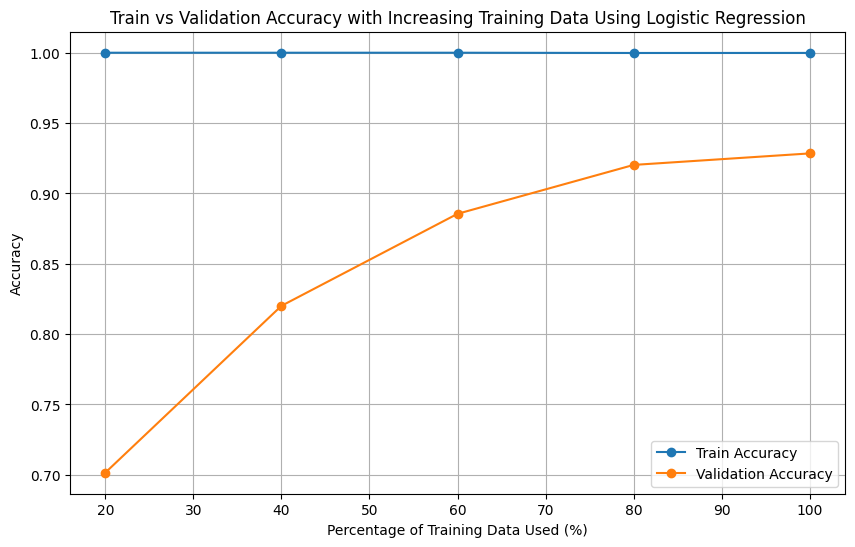

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

training_data = '/content/train_emoticon.csv'
validation_data = '/content/valid_emoticon.csv'

# reading the datasets
train_df = pd.read_csv(training_data)
valid_df = pd.read_csv(validation_data)

# splitting the 'input_emoticon' column into separate columns for each emoji
num_emojis = 13  # Number of unique emojis in each training example row
train_df_split = train_df['input_emoticon'].apply(lambda x: pd.Series(list(x)))
valid_df_split = valid_df['input_emoticon'].apply(lambda x: pd.Series(list(x)))
train_df_split.columns = [f'emoticon_{i}' for i in range(1, num_emojis + 1)]
valid_df_split.columns = [f'emoticon_{i}' for i in range(1, num_emojis + 1)]

# combining the split columns with the original 'label' column
train_df_final = pd.concat([train_df_split, train_df['label']], axis=1)
valid_df_final = pd.concat([valid_df_split, valid_df['label']], axis=1)

print(train_df_final.head())

# defining the fractions of the training data to use (from 20% to 100%)
fractions = np.linspace(0.2, 1.0, 5)

# initializing lists to store accuracies and parameter counts
train_accuracies = []
valid_accuracies_1 = []
parameter_counts = []

# initializing the OneHotEncoder and fit it on the combined training and validation data
encoder = OneHotEncoder(handle_unknown='ignore')
combined_data = pd.concat([train_df_final, valid_df_final]).drop(columns=['label'])
encoder.fit(combined_data)

# defining hyperparameter grid for GridSearchCV
param_grid = {
    'penalty': ['l2', 'l1'],
    'C': [0.01, 0.1, 1, 10],  # regularization strengths
    'solver': ['saga'],  # 'saga' solver supports l1, l2
    'max_iter': [1000, 2000]  # maximum number of iterations
}

# initializing GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

# encoding the full training data
X_train_full_encoded = encoder.transform(train_df_final.drop(columns=['label']))
y_train_full = train_df_final['label']

# fitting the model on the entire training set to find the best hyperparameters
grid_search.fit(X_train_full_encoded, y_train_full)

# extracting the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

for fraction in fractions:
    # subsampling the training data
    train_sample = train_df_final.sample(frac=fraction, random_state=42)

    # separating features and labels for the subsample
    X_train_sample = train_sample.drop(columns=['label'])
    y_train_sample = train_sample['label']

    # encoding the subsampled training data using the pre-fitted encoder
    X_train_encoded = encoder.transform(X_train_sample)

    # initializing and training the LogisticRegression with the best hyperparameters
    model = LogisticRegression(**best_params)
    model.fit(X_train_encoded, y_train_sample)

    # predicting on the training set and compute training accuracy
    y_train_pred = model.predict(X_train_encoded)
    train_accuracy = accuracy_score(y_train_sample, y_train_pred)

    # encoding and predicting on the validation set
    X_valid_encoded = encoder.transform(valid_df_final.drop(columns=['label']))
    y_valid_pred = model.predict(X_valid_encoded)
    valid_accuracy = accuracy_score(valid_df_final['label'], y_valid_pred)

    # calculating the number of parameters (features + intercepts)
    num_parameters = model.coef_.shape[1] + model.coef_.shape[0]

    # storing accuracies and parameter counts
    train_accuracies.append(train_accuracy)
    valid_accuracies_1.append(valid_accuracy)
    parameter_counts.append(num_parameters)

    print(f"Training on {fraction * 100:.1f}% of data - "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Accuracy: {valid_accuracy:.4f}, "
          f"Number of Parameters: {num_parameters}")

# plotting train and validation accuracies against data fractions
plt.figure(figsize=(10, 6))
plt.plot(fractions * 100, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(fractions * 100, valid_accuracies_1, label='Validation Accuracy', marker='o')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy with Increasing Training Data Using Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()



Applying SGD model and fitting training data into the model and plotting the results using the matplotlib.pyplot.

  emoticon_1 emoticon_2 emoticon_3 emoticon_4 emoticon_5 emoticon_6  \
0          😛          🛐          😻          😑          😣          🙠   
1          🛐          😑          😪          😛          🚼          🙯   
2          😛          🙯          😑          🚡          😣          🚼   
3          😛          🚼          🛐          🙐          😣          🙯   
4          🛐          🚟          🚼          😛          🙋          😑   

  emoticon_7 emoticon_8 emoticon_9 emoticon_10 emoticon_11 emoticon_12  \
0          🙯          🚼          😒           🙼           😑           🙯   
1          😣          🚅          😑           🙯           😹           😣   
2          🛐          🙲          😣           🙯           🛑           😑   
3          😑          🙪          😑           🙼           🛆           😣   
4          😣          🙯          😹           🙯           😑           😣   

  emoticon_13  label  
0           😣      0  
1           🙼      0  
2           🙼      0  
3           🙯      1  
4           🙼

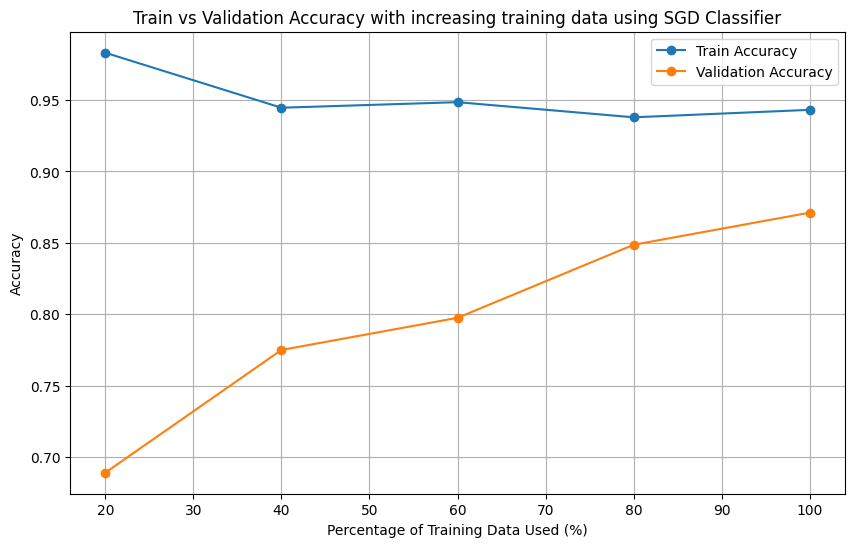

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

new_training_data = '/content/train_emoticon.csv'
new_validation_data = '/content/valid_emoticon.csv'

# reading the datasets
train_df = pd.read_csv(new_training_data)
valid_df = pd.read_csv(new_validation_data)

# spliting the 'input_emoticon' column into separate columns for each emoji
train_df_split = train_df['input_emoticon'].apply(lambda x: pd.Series(list(x)))
valid_df_split = valid_df['input_emoticon'].apply(lambda x: pd.Series(list(x)))

num_emojis = 13  # number of unique emojis in the each training example row
train_df_split.columns = [f'emoticon_{i}' for i in range(1, num_emojis + 1)]
valid_df_split.columns = [f'emoticon_{i}' for i in range(1, num_emojis + 1)]

# combining the split columns with the original 'label' column
train_df_final = pd.concat([train_df_split, train_df['label']], axis=1)
valid_df_final = pd.concat([valid_df_split, valid_df['label']], axis=1)

# showing the first few rows of the training set after splitting
print(train_df_final.head())

# defining the fractions of the training data to use (from 20% to 100%)
fractions = np.linspace(0.2, 1.0, 5)

# initializing lists to store accuracies and parameter counts
train_accuracies = []
valid_accuracies_2 = []
parameter_counts = []

# initializing the OneHotEncoder and fit it on the combined training and validation data
encoder = OneHotEncoder()
combined_data = pd.concat([train_df_final, valid_df_final]).drop(columns=['label'])
encoder.fit(combined_data)

# defining hyperparameter grid for GridSearchCV
param_grid = {
    'loss': ['modified_huber', 'perceptron', 'hinge', 'log_loss'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-2, 1e-1, 1],  # Regularization strengths
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'eta0': [0.01, 0.1, 1]  # Initial learning rates
}

# initializing GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(SGDClassifier(max_iter=1000), param_grid, cv=5, scoring='accuracy')

# encoding the full training data
X_train_full_encoded = encoder.transform(train_df_final.drop(columns=['label']))
y_train_full = train_df_final['label']

# fitting the model on the entire training set to find the best hyperparameters
grid_search.fit(X_train_full_encoded, y_train_full)

# extracting the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

for fraction in fractions:
    # subsample the training data
    train_sample = train_df_final.sample(frac=fraction, random_state=42)

    # separating features and labels for the subsample
    X_train_sample = train_sample.drop(columns=['label'])
    y_train_sample = train_sample['label']

    # encoding the subsampled training data using the pre-fitted encoder
    X_train_encoded = encoder.transform(X_train_sample)

    # intializing and train the SGDClassifier with the best hyperparameters
    model = SGDClassifier(**best_params, max_iter=1000, tol=1e-3)
    model.fit(X_train_encoded, y_train_sample)

    # predicting on the training set and compute training accuracy
    y_train_pred = model.predict(X_train_encoded)
    train_accuracy = accuracy_score(y_train_sample, y_train_pred)

    # encoding and predicting on the validation set
    X_valid_encoded = encoder.transform(valid_df_final.drop(columns=['label']))
    y_valid_pred = model.predict(X_valid_encoded)
    valid_accuracy = accuracy_score(valid_df_final['label'], y_valid_pred)

    # calculating the number of parameters (features + intercepts)
    num_parameters = model.coef_.shape[1] + model.coef_.shape[0]

    # storing accuracies and parameter counts
    train_accuracies.append(train_accuracy)
    valid_accuracies_2.append(valid_accuracy)
    parameter_counts.append(num_parameters)

    print(f"Training on {fraction * 100:.1f}% of data - "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Accuracy: {valid_accuracy:.4f}, "
          f"Number of Parameters: {num_parameters}")

# plotting train and validation accuracies against data fractions
plt.figure(figsize=(10, 6))
plt.plot(fractions * 100, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(fractions * 100, valid_accuracies_2, label='Validation Accuracy', marker='o')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy with increasing training data using SGD Classifier')
plt.legend()
plt.grid(True)
plt.show()


Pre-processing the dataset and extracting the useful information from the training data for better validation data accuracy.

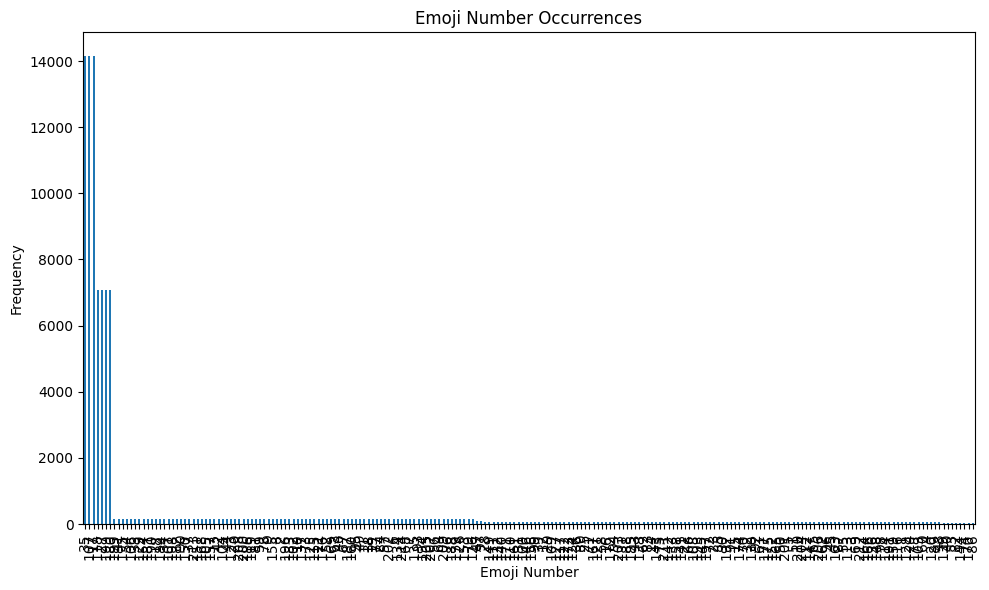

In [ ]:
# loading the CSV file
file_path = '/content/train_emoticon.csv'
df = pd.read_csv(file_path)

# spliting the emojis in the input_emoticon column
df['split_emojis'] = df['input_emoticon'].apply(list)

# creating a dictionary to assign each unique emoji a unique number
unique_emojis = sorted(set([emoji for sublist in df['split_emojis'] for emoji in sublist]))
emoji_to_num = {emoji: idx + 1 for idx, emoji in enumerate(unique_emojis)}

# replacing the emojis in each row with their corresponding numbers
df['emoticon_numbers'] = df['split_emojis'].apply(lambda emojis: [emoji_to_num[emoji] for emoji in emojis])

# flattening the list of numbers to count the occurrences
all_numbers = [num for sublist in df['emoticon_numbers'] for num in sublist]

# creating a pandas Series to count occurrences of each number
emoji_count = pd.Series(all_numbers).value_counts()

# plotting the histogram of occurrences
plt.figure(figsize=(10, 6))
emoji_count.plot(kind='bar')
plt.title('Emoji Number Occurrences')
plt.xlabel('Emoji Number')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Extraction of useful features from the original dataset by elimination of top 7 freqent emojis from the original dataset.

In [ ]:
# converting number to their respective emoji
num_to_emoji = {v: k for k, v in emoji_to_num.items()}

# obtaining the top 7 most frequent emoji numbers
top_7_numbers = emoji_count.nlargest(7)

# summing the occurrences of the top 7
sum_top_7 = top_7_numbers.sum()

# storing the corresponding emojis in a set
top_7_emojis = set([num_to_emoji[num] for num in top_7_numbers.index])

# printing the results
print("Sum of occurrences of the top 7 emojis:", sum_top_7)
print("Set of top 7 emojis:", top_7_emojis)



Sum of occurrences of the top 7 emojis: 70800
Set of top 7 emojis: {'😣', '😛', '🙼', '🛐', '😑', '🚼', '🙯'}


Loading training and validation data into dataframe and extracing useful information from it.

In [ ]:
top_7_emojis = {'😛', '🛐', '🙯', '😑', '😣', '🚼', '🙼'}  # Replace with actual top 7 emojis

# loading the train_emoticon.csv file
train_file_path = '/content/train_emoticon.csv'
train_df = pd.read_csv(train_file_path)

# spliting the emojis in the input_emoticon column
train_df['split_emojis'] = train_df['input_emoticon'].apply(list)

# function to remove the top 7 emojis from each row
def remove_top_7_emojis(emojis):
    return [emoji for emoji in emojis if emoji not in top_7_emojis]

# removing the top 7 emojis from the training dataset
train_df['filtered_emoticons'] = train_df['split_emojis'].apply(remove_top_7_emojis)

# joining the filtered emojis back into a string
train_df['filtered_emoticons_str'] = train_df['filtered_emoticons'].apply(''.join)

# saving the new training dataset to a CSV file without the top 7 emojis
train_df[['filtered_emoticons_str', 'label']].to_csv('train_dataset_without_top7_emojis.csv', index=False)

print("New CSV file 'train_dataset_without_top7_emojis.csv' has been created, excluding the top 7 most frequent emojis.")


# similary for validation data

# loading the valid_emoticon.csv file
valid_file_path = 'content/valid_emoticon.csv'
valid_df = pd.read_csv(valid_file_path)

# spliting the emojis in the input_emoticon column
valid_df['split_emojis'] = valid_df['input_emoticon'].apply(list)

# removing the top 7 emojis from the valid dataset
valid_df['filtered_emoticons'] = valid_df['split_emojis'].apply(remove_top_7_emojis)

# joining the filtered emojis back into a string
valid_df['filtered_emoticons_str'] = valid_df['filtered_emoticons'].apply(''.join)

# saving the new valid dataset to a CSV file without the top 7 emojis
valid_df[['filtered_emoticons_str', 'label']].to_csv('valid_dataset_without_top7_emojis.csv', index=False)

print("New CSV file 'valid_dataset_without_top7_emojis.csv' has been created, excluding the top 7 most frequent emojis.")

New CSV file 'train_dataset_without_top7_emojis.csv' has been created, excluding the top 7 most frequent emojis.
New CSV file 'valid_dataset_without_top7_emojis.csv' has been created, excluding the top 7 most frequent emojis.


Applying SGD to the new training data to build the model. Plotting the training and validation data accuracy for the built model.

  emoticon_1 emoticon_2 emoticon_3  label
0          😻          🙠          😒      0
1          😪          🚅          😹      0
2          🚡          🙲          🛑      0
3          🙐          🙪          🛆      1
4          🚟          🙋          😹      1
Best hyperparameters: {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'invscaling', 'loss': 'perceptron', 'penalty': 'l2'}
Training on 20.0% of data - Train Accuracy: 0.9760, Validation Accuracy: 0.8139, Number of Parameters: 502
Training on 40.0% of data - Train Accuracy: 0.9891, Validation Accuracy: 0.9100, Number of Parameters: 502
Training on 60.0% of data - Train Accuracy: 0.9885, Validation Accuracy: 0.9387, Number of Parameters: 502
Training on 80.0% of data - Train Accuracy: 0.9861, Validation Accuracy: 0.9571, Number of Parameters: 502
Training on 100.0% of data - Train Accuracy: 0.9922, Validation Accuracy: 0.9632, Number of Parameters: 502


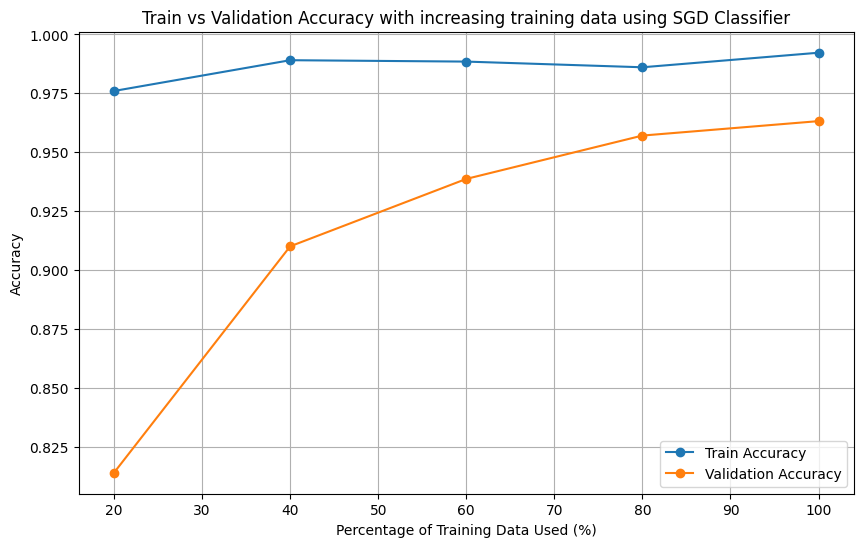

In [ ]:
new_training_data = 'train_dataset_without_top7_emojis.csv'
new_validation_data = 'valid_dataset_without_top7_emojis.csv'

# reading the datasets
train_df = pd.read_csv(new_training_data)
valid_df = pd.read_csv(new_validation_data)

# spliting the 'filtered_emoticons_str' column into separate columns for each emoji
train_df_split = train_df['filtered_emoticons_str'].apply(lambda x: pd.Series(list(x)))
valid_df_split = valid_df['filtered_emoticons_str'].apply(lambda x: pd.Series(list(x)))

num_emojis = 3  # number of unique emojis in the each training example row
train_df_split.columns = [f'emoticon_{i}' for i in range(1, num_emojis + 1)]
valid_df_split.columns = [f'emoticon_{i}' for i in range(1, num_emojis + 1)]

# combining the split columns with the original 'label' column
train_df_final = pd.concat([train_df_split, train_df['label']], axis=1)
valid_df_final = pd.concat([valid_df_split, valid_df['label']], axis=1)

# showing the first few rows of the training set after splitting
print(train_df_final.head())

# defining the fractions of the training data to use (from 20% to 100%)
fractions = np.linspace(0.2, 1.0, 5)

# initializing lists to store accuracies and parameter counts
train_accuracies = []
valid_accuracies_3 = []
parameter_counts = []

# initializing the OneHotEncoder and fit it on the combined training and validation data
encoder = OneHotEncoder()
combined_data = pd.concat([train_df_final, valid_df_final]).drop(columns=['label'])
encoder.fit(combined_data)

# defining hyperparameter grid for GridSearchCV
param_grid = {
    'loss': ['modified_huber', 'perceptron', 'hinge', 'log_loss'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-2, 1e-1, 1],  # Regularization strengths
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'eta0': [0.01, 0.1, 1]  # Initial learning rates
}

# initializing GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(SGDClassifier(max_iter=1000), param_grid, cv=5, scoring='accuracy')

# encoding the full training data
X_train_full_encoded = encoder.transform(train_df_final.drop(columns=['label']))
y_train_full = train_df_final['label']

# fitting the model on the entire training set to find the best hyperparameters
grid_search.fit(X_train_full_encoded, y_train_full)

# extracting the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

for fraction in fractions:
    # subsample the training data
    train_sample = train_df_final.sample(frac=fraction, random_state=42)

    # separating features and labels for the subsample
    X_train_sample = train_sample.drop(columns=['label'])
    y_train_sample = train_sample['label']

    # encoding the subsampled training data using the pre-fitted encoder
    X_train_encoded = encoder.transform(X_train_sample)

    # intializing and train the SGDClassifier with the best hyperparameters
    model = SGDClassifier(**best_params, max_iter=1000, tol=1e-3)
    model.fit(X_train_encoded, y_train_sample)

    # predicting on the training set and compute training accuracy
    y_train_pred = model.predict(X_train_encoded)
    train_accuracy = accuracy_score(y_train_sample, y_train_pred)

    # encoding and predicting on the validation set
    X_valid_encoded = encoder.transform(valid_df_final.drop(columns=['label']))
    y_valid_pred = model.predict(X_valid_encoded)
    valid_accuracy = accuracy_score(valid_df_final['label'], y_valid_pred)

    # calculating the number of parameters (features + intercepts)
    num_parameters = model.coef_.shape[1] + model.coef_.shape[0]

    # storing accuracies and parameter counts
    train_accuracies.append(train_accuracy)
    valid_accuracies_3.append(valid_accuracy)
    parameter_counts.append(num_parameters)

    print(f"Training on {fraction * 100:.1f}% of data - "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Accuracy: {valid_accuracy:.4f}, "
          f"Number of Parameters: {num_parameters}")

# plotting train and validation accuracies against data fractions
plt.figure(figsize=(10, 6))
plt.plot(fractions * 100, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(fractions * 100, valid_accuracies_3, label='Validation Accuracy', marker='o')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy with increasing training data using SGD Classifier')
plt.legend()
plt.grid(True)
plt.show()


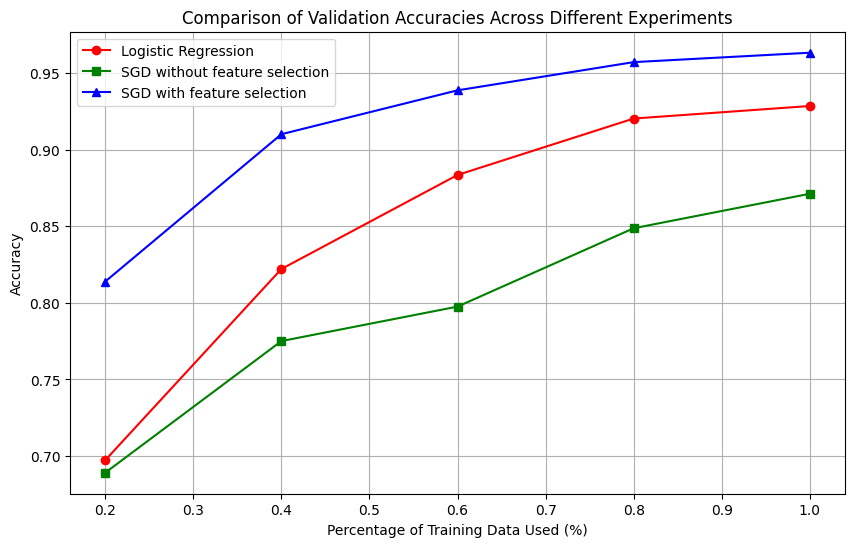

In [ ]:
plt.figure(figsize=(10, 6))

# Example: you might have three different lists of validation accuracies
plt.plot(fractions, valid_accuracies_1, label='Logistic Regression', marker='o', color='red')
plt.plot(fractions, valid_accuracies_2, label='SGD without feature selection', marker='s', color='green')
plt.plot(fractions, valid_accuracies_3, label='SGD with feature selection', marker='^', color='blue')


# Add more lines if necessary for more experiments or metrics
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Accuracy')
plt.title('Comparison of Validation Accuracies Across Different Experiments')
plt.legend()
plt.grid(True)
plt.show()

Conclusion :
Best model => SGD model with feature selection
This model is giving around 96% accuracy on validation set for 100% training data.

Predicting the labels for the test data given for the emoticon dataset.

In [ ]:
top_7_emojis = {'😛', '🛐', '🙯', '😑', '😣', '🚼', '🙼'}

# loading the test_emoticon.csv file
test_file_path = '/content/test_emoticon.csv'
test_df = pd.read_csv(test_file_path)

# spliting the emojis in the input_emoticon column
test_df['split_emojis'] = test_df['input_emoticon'].apply(list)

# removing the top 7 emojis from the testing dataset
test_df['filtered_emoticons'] = test_df['split_emojis'].apply(remove_top_7_emojis)

# joining the filtered emojis back into a string
test_df['filtered_emoticons_str'] = test_df['filtered_emoticons'].apply(''.join)

# saving the new testing dataset to a CSV file without the top 7 emojis
test_df[['filtered_emoticons_str']].to_csv('test_dataset_without_top7_emojis.csv', index=False)

print("New CSV file 'test_dataset_without_top7_emojis.csv' has been created, excluding the top 7 most frequent emojis.")

# splitting the 'filtered_emoticons_str' column into separate columns for each emoji
num_emojis = 3
test_df_split = test_df['filtered_emoticons_str'].apply(lambda x: pd.Series(list(x)))
test_df_split.columns = [f'emoticon_{i}' for i in range(1, num_emojis + 1)]

# intializing OneHotEncoder and fit it on the combined training and validation data
encoder = OneHotEncoder(handle_unknown='ignore')
combined_data = pd.concat([train_df_final.drop(columns=['label']), valid_df_final.drop(columns=['label'])])
encoder.fit(combined_data)

# encoding the test data using the pre-fitted encoder
X_test_encoded = encoder.transform(test_df_split)

# predicting using the trained model
test_predictions = model.predict(X_test_encoded)

# saving the predictions to a text file
with open('pred_emoticon.txt', 'w') as f:
    for prediction in test_predictions:
        f.write(str(prediction) + '\n')

print("Predictions saved to 'pred_emoticon.txt'.")

New CSV file 'test_dataset_without_top7_emojis.csv' has been created, excluding the top 7 most frequent emojis.
Predictions saved to 'prediction.txt'.


# Task 1.2

# Import necessary libraries:

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


# Loading datasets:

In [ ]:

# Load training feature data
training_data = np.load("/content/train_feature.npz", allow_pickle=True)
train_features = training_data['features']
train_labels = training_data['label']

# Load validation feature data
validation_data = np.load("/content/valid_feature.npz", allow_pickle=True)
valid_features = validation_data['features']
valid_labels = validation_data['label']


Data Processing

In [ ]:

# Ensure labels are in integer format
train_labels = train_labels.astype(int)  # Assumes classes are 0 and 1
valid_labels = valid_labels.astype(int)  # Assumes classes are 0 and 1

# Flatten the feature arrays from (samples, 13, 786) to (samples, 13 * 786)
num_train_samples = train_features.shape[0]
num_valid_samples = valid_features.shape[0]

flat_train_features = train_features.reshape(num_train_samples, -1)
flat_valid_features = valid_features.reshape(num_valid_samples, -1)

# Normalize the feature data
scaler = StandardScaler()
flat_train_features = scaler.fit_transform(flat_train_features)
flat_valid_features = scaler.transform(flat_valid_features)


# Using Logistic Regression:

Training with 20% of the data:
Validation Accuracy (Logistic Regression): 0.9530
Confusion Matrix:
 [[240  12]
 [ 11 226]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       252
           1       0.95      0.95      0.95       237

    accuracy                           0.95       489
   macro avg       0.95      0.95      0.95       489
weighted avg       0.95      0.95      0.95       489

-----

Training with 40% of the data:
Validation Accuracy (Logistic Regression): 0.9652
Confusion Matrix:
 [[245   7]
 [ 10 227]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       252
           1       0.97      0.96      0.96       237

    accuracy                           0.97       489
   macro avg       0.97      0.97      0.97       489
weighted avg       0.97      0.97      0.97       489

-----

Training with 60% of the data:
Validat

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

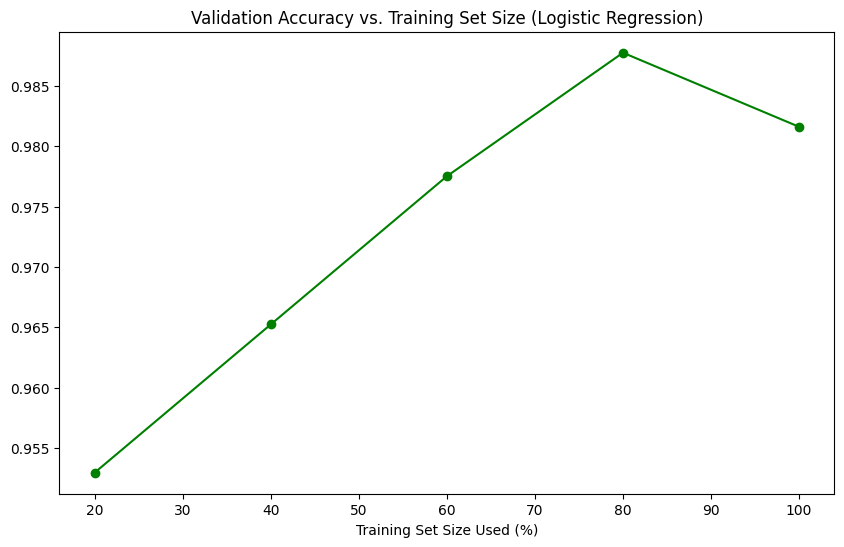

In [ ]:
from sklearn.linear_model import LogisticRegression

# Different training set sizes to use (as percentages)
data_fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
performance_scores_logreg = []

# Train and evaluate the model for each fraction of the training data
for fraction in data_fractions:
    # Determine the subset size
    subset_size = int(num_train_samples * fraction)
    subset_train_features = flat_train_features[:subset_size]
    subset_train_labels = train_labels[:subset_size]

    # Initialize and train the LogisticRegression model
    classifier = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)  # Adjust solver and max_iter if needed
    classifier.fit(subset_train_features, subset_train_labels)

    # Predict on the validation data
    valid_predictions = classifier.predict(flat_valid_features)

    # Measure the accuracy on the validation set
    accuracy = accuracy_score(valid_labels, valid_predictions)
    performance_scores_logreg.append(accuracy)

    # Output metrics for each training fraction
    print(f"Training with {int(fraction * 100)}% of the data:")
    print(f"Validation Accuracy (Logistic Regression): {accuracy:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(valid_labels, valid_predictions))
    print("Classification Report:\n", classification_report(valid_labels, valid_predictions))
    print("-----\n")

# Visualize the accuracy versus training data fraction for LogisticRegression
plt.figure(figsize=(10, 6))
plt.plot([int(f * 100) for f in data_fractions], performance_scores_logreg, marker='o', color='green')
plt.title("Validation Accuracy vs. Training Set Size (Logistic Regression)")
plt.xlabel("Training Set Size Used (%)")
plt


# Trainable parameters  under 10,000

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Initialize the LogisticRegression model
classifier = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)

# Train the model with a subset of the data
classifier.fit(subset_train_features, subset_train_labels)

# Get the number of trainable parameters
num_trainable_params = np.prod(classifier.coef_.shape) + np.prod(classifier.intercept_.shape)

print(f"Number of trainable parameters: {num_trainable_params}")


Number of trainable parameters: 9985


# Using K Nearest Neighbours:

Training with 20% of the data:
Validation Accuracy (KNN, Weighted & Tuned): 0.9530
Best Hyperparameters: {'n_neighbors': 7, 'weights': 'distance'}
Confusion Matrix:
 [[241  11]
 [ 12 225]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       252
           1       0.95      0.95      0.95       237

    accuracy                           0.95       489
   macro avg       0.95      0.95      0.95       489
weighted avg       0.95      0.95      0.95       489

-----

Training with 40% of the data:
Validation Accuracy (KNN, Weighted & Tuned): 0.9673
Best Hyperparameters: {'n_neighbors': 7, 'weights': 'distance'}
Confusion Matrix:
 [[244   8]
 [  8 229]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       252
           1       0.97      0.97      0.97       237

    accuracy                           0.97       489
   macro avg       0.9

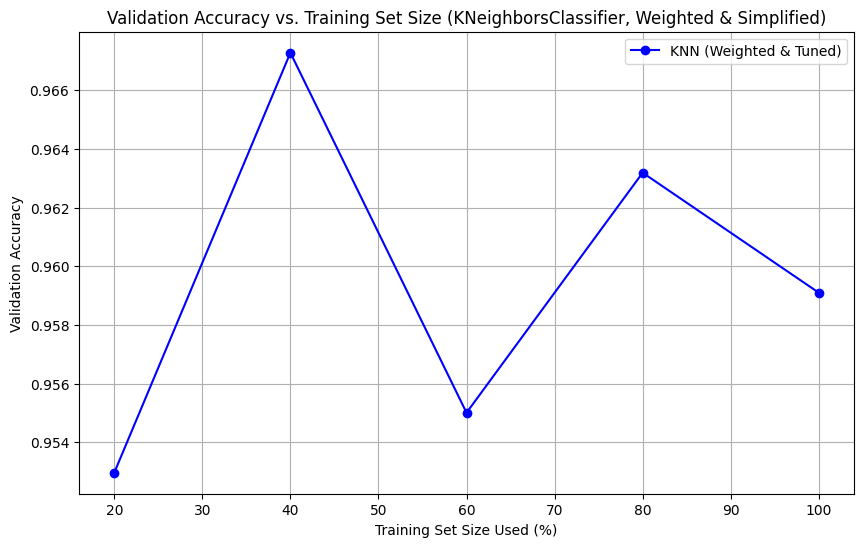

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Different training set sizes to use (as percentages)
data_fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
performance_scores_knn = []

# Simplified hyperparameter tuning using GridSearchCV
param_grid = {
    'n_neighbors': [5, 7],  # Fewer neighbor options
    'weights': ['distance'],  # Only distance-based weighting
}

# Initialize GridSearchCV with KNeighborsClassifier
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='accuracy')  # Reduced to 3-fold cross-validation

# Train and evaluate the model for each fraction of the training data
for fraction in data_fractions:
    # Determine the subset size
    subset_size = int(num_train_samples * fraction)
    subset_train_features = flat_train_features[:subset_size]
    subset_train_labels = train_labels[:subset_size]

    # Fit the KNeighborsClassifier using GridSearchCV for hyperparameter tuning
    grid_search_knn.fit(subset_train_features, subset_train_labels)

    # Get the best parameters after hyperparameter tuning
    best_knn = grid_search_knn.best_estimator_

    # Predict on the validation data
    valid_predictions = best_knn.predict(flat_valid_features)

    # Measure the accuracy on the validation set
    accuracy = accuracy_score(valid_labels, valid_predictions)
    performance_scores_knn.append(accuracy)

    # Output metrics for each training fraction
    print(f"Training with {int(fraction * 100)}% of the data:")
    print(f"Validation Accuracy (KNN, Weighted & Tuned): {accuracy:.4f}")
    print("Best Hyperparameters:", grid_search_knn.best_params_)
    print("Confusion Matrix:\n", confusion_matrix(valid_labels, valid_predictions))
    print("Classification Report:\n", classification_report(valid_labels, valid_predictions))
    print("-----\n")

# Visualize the accuracy versus training data fraction for KNeighborsClassifier
plt.figure(figsize=(10, 6))
plt.plot([int(f * 100) for f in data_fractions], performance_scores_knn, marker='o', color='blue', label='KNN (Weighted & Tuned)')
plt.title("Validation Accuracy vs. Training Set Size (KNeighborsClassifier, Weighted & Simplified)")
plt.xlabel("Training Set Size Used (%)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()


# Using SVC Classifier:

Training with 20% of the data:
Validation Accuracy: 0.9448
Confusion Matrix:
 [[241  11]
 [ 16 221]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       252
           1       0.95      0.93      0.94       237

    accuracy                           0.94       489
   macro avg       0.95      0.94      0.94       489
weighted avg       0.94      0.94      0.94       489

-----

Training with 40% of the data:
Validation Accuracy: 0.9673
Confusion Matrix:
 [[244   8]
 [  8 229]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       252
           1       0.97      0.97      0.97       237

    accuracy                           0.97       489
   macro avg       0.97      0.97      0.97       489
weighted avg       0.97      0.97      0.97       489

-----

Training with 60% of the data:
Validation Accuracy: 0.9714
Confusion Matrix:
 [[24

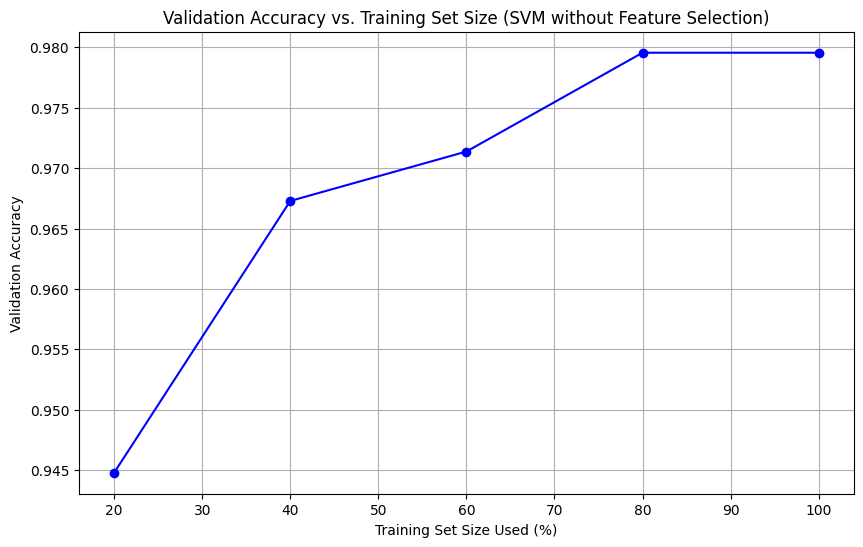

In [ ]:

# Different training set sizes to use (as percentages)
data_fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
performance_scores = []

# Train and evaluate the model for each fraction of the training data
for fraction in data_fractions:
    # Determine the subset size
    subset_size = int(num_train_samples * fraction)
    subset_train_features = flat_train_features[:subset_size]
    subset_train_labels = train_labels[:subset_size]

    # Initialize and train the SVM model
    classifier = SVC(kernel='linear', random_state=42)
    classifier.fit(subset_train_features, subset_train_labels)

    # Predict on the validation data
    valid_predictions = classifier.predict(flat_valid_features)

    # Measure the accuracy on the validation set
    accuracy = accuracy_score(valid_labels, valid_predictions)
    performance_scores.append(accuracy)

    # Output metrics for each training fraction
    print(f"Training with {int(fraction * 100)}% of the data:")
    print(f"Validation Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(valid_labels, valid_predictions))
    print("Classification Report:\n", classification_report(valid_labels, valid_predictions))
    print("-----\n")

# Visualize the accuracy versus training data fraction
plt.figure(figsize=(10, 6))
plt.plot([int(f * 100) for f in data_fractions], performance_scores, marker='o', color='blue')
plt.title("Validation Accuracy vs. Training Set Size (SVM without Feature Selection)")
plt.xlabel("Training Set Size Used (%)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()


# Trainable parameters  under 10,000





In [ ]:
from sklearn.svm import SVC
import numpy as np

# Initialize the SVC model with a linear kernel
classifier = SVC(kernel='linear', random_state=42)

# Train the model on a subset of the data
classifier.fit(subset_train_features, subset_train_labels)

# Get the number of trainable parameters (weights + bias)
num_trainable_params = np.prod(classifier.coef_.shape) + np.prod(classifier.intercept_.shape)

print(f"Number of trainable parameters: {num_trainable_params}")


Number of trainable parameters: 9985


# Using Random Forest Classifer:

Training with 20% of the data:
Validation Accuracy: 0.96
Confusion Matrix:
 [[240  12]
 [  9 228]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       252
           1       0.95      0.96      0.96       237

    accuracy                           0.96       489
   macro avg       0.96      0.96      0.96       489
weighted avg       0.96      0.96      0.96       489

-----

Training with 40% of the data:
Validation Accuracy: 0.97
Confusion Matrix:
 [[244   8]
 [  6 231]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       252
           1       0.97      0.97      0.97       237

    accuracy                           0.97       489
   macro avg       0.97      0.97      0.97       489
weighted avg       0.97      0.97      0.97       489

-----

Training with 60% of the data:
Validation Accuracy: 0.98
Confusion Matrix:
 [[248   4]

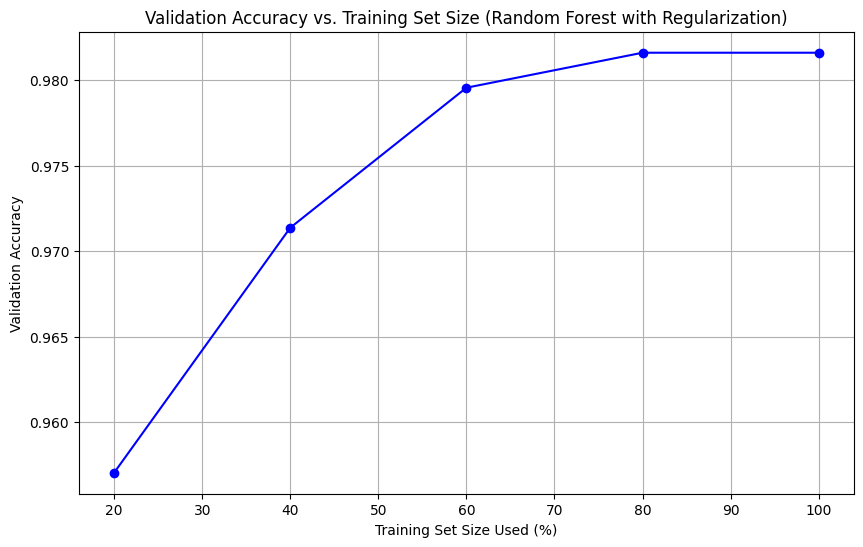

In [ ]:


# Different fractions of the training data to utilize
data_fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
model_accuracies = []

# Train and evaluate the model for each fraction of the training data
for fraction in data_fractions:
    # Determine the size of the subset
    subset_size = int(num_train_samples * fraction)
    subset_train_features = flat_train_features[:subset_size]
    subset_train_labels = train_labels[:subset_size]

    # Initialize and train the Random Forest model with regularization parameters
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,              # Maximum depth of each tree
        min_samples_split=5,       # Minimum samples required to split an internal node
        min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
        random_state=42
    )

    rf_model.fit(subset_train_features, subset_train_labels)

    # Predict on the validation data
    valid_predictions = rf_model.predict(flat_valid_features)

    # Measure the accuracy on the validation set
    accuracy = accuracy_score(valid_labels, valid_predictions)
    model_accuracies.append(accuracy)

    # Output metrics for each training fraction
    print(f"Training with {int(fraction * 100)}% of the data:")
    print(f"Validation Accuracy: {accuracy:.2f}")
    print("Confusion Matrix:\n", confusion_matrix(valid_labels, valid_predictions))
    print("Classification Report:\n", classification_report(valid_labels, valid_predictions))
    print("-----\n")

# Visualize the accuracy versus training data fraction
plt.figure(figsize=(10, 6))
plt.plot([int(f * 100) for f in data_fractions], model_accuracies, marker='o', color='blue')
plt.title("Validation Accuracy vs. Training Set Size (Random Forest with Regularization)")
plt.xlabel("Training Set Size Used (%)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()


# Combined overall plot:

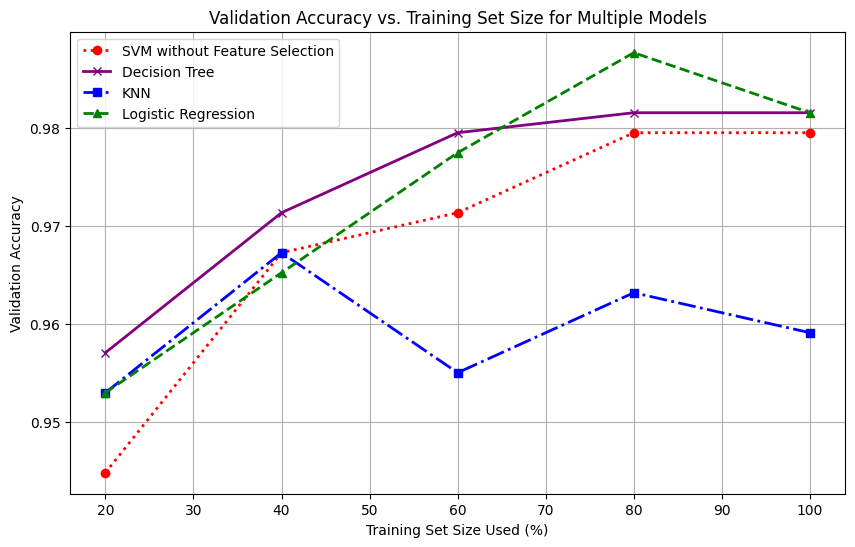

In [ ]:
# Visualize the accuracy versus training data fraction for SVM, Decision Tree, KNN, and Logistic Regression
plt.figure(figsize=(10, 6))

# Plot for SVM without Feature Selection
plt.plot([int(f * 100) for f in data_fractions], performance_scores, marker='o', color='red', label='SVM without Feature Selection', linewidth=2, linestyle='dotted')

# Plot for Decision Tree
plt.plot([int(f * 100) for f in data_fractions], model_accuracies, marker='x', color='purple', label='Decision Tree', linewidth=2)

# Plot for KNeighborsClassifier
plt.plot([int(f * 100) for f in data_fractions], performance_scores_knn, marker='s', color='blue', label='KNN', linewidth=2, linestyle='dashdot')

# Plot for Logistic Regression
plt.plot([int(f * 100) for f in data_fractions], performance_scores_logreg, marker='^', color='green', label='Logistic Regression', linewidth=2, linestyle='dashed')

# Adding titles and labels
plt.title("Validation Accuracy vs. Training Set Size for Multiple Models")
plt.xlabel("Training Set Size Used (%)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.legend()

# Show the combined plot
plt.show()


# Random Forest is taken as the ideal model  performing better at maximum instances.

# Test data Predictions:

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the test features from the .npz file
test_data = np.load('/content/test_feature.npz')
flat_test_features = test_data['features']  # Assuming 'features' is the correct key in the .npz file

# Check the shape of the test data and flatten it if necessary
print(f"Original shape of test data: {flat_test_features.shape}")

# Reshape the test data to 2D if it's 3D
if len(flat_test_features.shape) == 3:
    flat_test_features = flat_test_features.reshape(flat_test_features.shape[0], -1)

print(f"Reshaped test data to: {flat_test_features.shape}")

# Assuming flat_train_features and train_labels are already loaded and prepared
# Initialize the Random Forest model with the same regularization parameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Train the model on the full training dataset
rf_model.fit(flat_train_features, train_labels)

# Make predictions on the test dataset
test_predictions = rf_model.predict(flat_test_features)

# Save the predictions to a .txt file
output_file = '/content/pred_test_feature.txt'
np.savetxt(output_file, test_predictions, fmt='%d')  # Save as integers

print(f"Predictions saved to {output_file}")


Original shape of test data: (2232, 13, 768)
Reshaped test data to: (2232, 9984)
Predictions saved to /content/pred_test_feature.txt


# Task 1.3


# Importing Libraries:

In [ ]:

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Removing repeatable string combination:

In [ ]:

# Load the training data
data = pd.read_csv("/content/train_text_seq.csv")

# Step 1: Remove leading zeros from each string in the dataset
data['cleaned_str'] = data['input_str'].apply(lambda x: x[3:])  # Remove first 3 characters

# Function to extract substrings of variable lengths from a sequence
def get_substrings(sequence, min_size=2, max_size=7):
    substrings = []
    for length in range(min_size, max_size + 1):
        substrings.extend([sequence[i:i+length] for i in range(len(sequence) - length + 1)])
    return substrings

# Step 2: Gather all substrings from each sequence and count their occurrences
substring_frequency = Counter()  # Count global occurrences of substrings
individual_counts = []  # Store individual counts for each sequence

# Iterate through each sequence and process it
for sequence in data['cleaned_str']:
    substrings = get_substrings(sequence)  # Extract substrings from the current sequence
    substring_frequency.update(substrings)  # Update the global substring count
    individual_counts.append(Counter(substrings))  # Store counts for each sequence

# Step 3: Identify substrings that appear the same number of times in every sequence
consistent_substrings = {}

# Check for substrings that appear the same number of times in all sequences
for substring, count in substring_frequency.items():
    occurrences = [count_per_sequence.get(substring, 0) for count_per_sequence in individual_counts]

    # Ensure that the substring appears with the same frequency in each sequence
    if len(set(occurrences)) == 1 and occurrences[0] > 0:
        consistent_substrings[substring] = occurrences[0]  # Record the substring and its count

# Step 4: Print the consistent substrings and their frequencies
print("Substrings that appear the same number of times across all sequences:")
for substring, frequency in consistent_substrings.items():
    print(f"Substring '{substring}' appears {frequency} times in every sequence.")


Substrings that appear the same number of times across all sequences:
Substring '1596' appears 2 times in every sequence.
Substring '15436' appears 1 times in every sequence.


# Data Analysis:

In [ ]:

# Load the data from the CSV file
dataset = pd.read_csv("/content/train_text_seq.csv")

# Step 1: Remove the first three characters (leading zeros) from the input strings
dataset['cleaned_string'] = dataset['input_str'].apply(lambda x: x[3:])

# Function to generate substrings of a specific length from a sequence
def generate_substrings(seq, sub_length):
    return [seq[i:i + sub_length] for i in range(len(seq) - sub_length + 1)]

# Step 2: Initialize counters for different substring lengths (3, 4, 5, and 6)
subseq_length_3 = Counter()
subseq_length_4 = Counter()
subseq_length_5 = Counter()
subseq_length_6 = Counter()

# Step 3: Count occurrences of substrings of lengths 3, 4, 5, and 6 for each sequence
for string in dataset['cleaned_string']:
    subseq_length_3.update(generate_substrings(string, 3))
    subseq_length_4.update(generate_substrings(string, 4))
    subseq_length_5.update(generate_substrings(string, 5))
    subseq_length_6.update(generate_substrings(string, 6))

# Step 4: Retrieve the top 10 most common substrings for each length
top_3_substrings = subseq_length_3.most_common(10)
top_4_substrings = subseq_length_4.most_common(10)
top_5_substrings = subseq_length_5.most_common(10)
top_6_substrings = subseq_length_6.most_common(10)

# Step 5: Print out the results for each substring length
print("Top 10 most frequent 3-length substrings:")
for subseq, count in top_3_substrings:
    print(f"Substring '{subseq}' appears {count} times.")

print("\nTop 10 most frequent 4-length substrings:")
for subseq, count in top_4_substrings:
    print(f"Substring '{subseq}' appears {count} times.")

print("\nTop 10 most frequent 5-length substrings:")
for subseq, count in top_5_substrings:
    print(f"Substring '{subseq}' appears {count} times.")

print("\nTop 10 most frequent 6-length substrings:")
for subseq, count in top_6_substrings:
    print(f"Substring '{subseq}' appears {count} times.")


Top 10 most frequent 3-length substrings:
Substring '262' appears 14595 times.
Substring '614' appears 14487 times.
Substring '596' appears 14246 times.
Substring '159' appears 14161 times.
Substring '415' appears 7567 times.
Substring '436' appears 7303 times.
Substring '154' appears 7267 times.
Substring '422' appears 7163 times.
Substring '464' appears 7156 times.
Substring '543' appears 7144 times.

Top 10 most frequent 4-length substrings:
Substring '1596' appears 14160 times.
Substring '5436' appears 7134 times.
Substring '1543' appears 7082 times.
Substring '4262' appears 5580 times.
Substring '4159' appears 5388 times.
Substring '6142' appears 5113 times.
Substring '5962' appears 4942 times.
Substring '6141' appears 4276 times.
Substring '2621' appears 4155 times.
Substring '6262' appears 3875 times.

Top 10 most frequent 5-length substrings:
Substring '15436' appears 7080 times.
Substring '41596' appears 5388 times.
Substring '15962' appears 4941 times.
Substring '21596' appea

# Data Sorting:

In [ ]:

# Load the training and validation datasets
train_data = pd.read_csv("/content/train_text_seq.csv")
valid_data = pd.read_csv("/content/valid_text_seq.csv")

# Substrings to remove from the strings
remove_substrings_list = ['15436', '1596', '464', '614', '262', '422', '284']

# Function to remove the specified substrings from a sequence
def filter_substrings(sequence, substrings):
    for substring in substrings:
        sequence = sequence.replace(substring, '')  # Remove each specified substring
    return sequence

# Preprocessing function for the dataset
def clean_data(df):
    # Remove leading zeros
    df['cleaned_str'] = df['input_str'].apply(lambda x: x[3:])
    # Remove specific substrings
    df['modified_str'] = df['cleaned_str'].apply(lambda x: filter_substrings(x, remove_substrings_list))
    # Add a new column for the length of the modified string
    df['modified_length'] = df['modified_str'].apply(len)
    # Filter only strings with length 13 after modification
    df = df[df['modified_length'] == 13]
    return df

# Clean both the training and validation datasets
train_data = clean_data(train_data)
valid_data = clean_data(valid_data)


# Function to encode the strings as integer values
def string_to_int_encoding(df):
    # Create a set of all unique characters from the modified strings
    unique_chars = sorted(list(set("".join(df['modified_str'].values))))
    # Create a dictionary to map each character to a unique integer
    char_to_integer = {char: idx + 1 for idx, char in enumerate(unique_chars)}
    # Encode the modified string using the character to integer mapping
    df.loc[:, 'encoded_str'] = df['modified_str'].apply(lambda x: [char_to_integer[char] for char in x])  # Fix warning by using .loc
    return df, char_to_integer

# Apply the encoding function to both the training and validation data
train_data, char_to_integer_mapping = string_to_int_encoding(train_data)
valid_data, _ = string_to_int_encoding(valid_data)

# Prepare the data for XGBoost
# Flatten the list of integers for each encoded string to create feature columns
X_train_features = pd.DataFrame(train_data['encoded_str'].tolist())
y_train_labels = train_data['label'].values

X_valid_features = pd.DataFrame(valid_data['encoded_str'].tolist())
y_valid_labels = valid_data['label'].values


# Define global accuracy lists

In [ ]:

training_accuracies = []
validation_accuracies = []
train_accuracies3 = []
valid_accuracies3 = []
train_accuracies2 = []
valid_accuracies2 = []



# Using Xg Boosting without H.parameters

Training with 10.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.7072
Training with 20.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.7918
Training with 30.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.8026
Training with 40.0% of data - Train Accuracy: 0.9996, Validation Accuracy: 0.8395
Training with 50.0% of data - Train Accuracy: 0.9991, Validation Accuracy: 0.8460
Training with 60.0% of data - Train Accuracy: 0.9990, Validation Accuracy: 0.8525
Training with 70.0% of data - Train Accuracy: 0.9989, Validation Accuracy: 0.8590
Training with 80.0% of data - Train Accuracy: 0.9974, Validation Accuracy: 0.8764
Training with 90.0% of data - Train Accuracy: 0.9958, Validation Accuracy: 0.8720
Training with 100.0% of data - Train Accuracy: 0.9952, Validation Accuracy: 0.8720


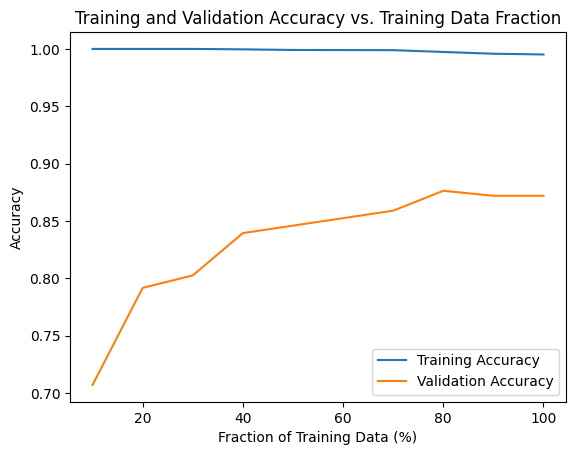

In [ ]:

# Define the fractions of the training dataset to be used, ranging from 10% to 100%
data_fractions = np.linspace(0.1, 1.0, 10)



# Loop over different fractions of the training dataset
for fraction in data_fractions:
    # Select a subset of the training data
    subset_size = int(fraction * train_data.shape[0])
    X_train_subset = X_train_features[:subset_size]
    y_train_subset = y_train_labels[:subset_size]

    # Initialize the XGBoost classifier model (removed use_label_encoder)
    xgb_model = xgb.XGBClassifier(eval_metric='logloss')

    # Fit the model with the training subset
    xgb_model.fit(X_train_subset, y_train_subset)

    # Make predictions on the training data subset
    train_predictions = xgb_model.predict(X_train_subset)

    # Evaluate the model's performance using accuracy on training data
    train_accuracy = accuracy_score(y_train_subset, train_predictions)

    # Make predictions on the validation dataset
    valid_predictions = xgb_model.predict(X_valid_features)

    # Evaluate the model's performance using accuracy on validation data
    valid_accuracy = accuracy_score(y_valid_labels, valid_predictions)

    # Store the results
    training_accuracies.append(train_accuracy)
    validation_accuracies.append(valid_accuracy)

    # Print the accuracies
    print(f"Training with {fraction * 100:.1f}% of data - "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Accuracy: {valid_accuracy:.4f}")

# You can plot the training and validation accuracies to see the trend
import matplotlib.pyplot as plt

plt.plot(data_fractions * 100, training_accuracies, label='Training Accuracy')
plt.plot(data_fractions * 100, validation_accuracies, label='Validation Accuracy')
plt.xlabel('Fraction of Training Data (%)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Training Data Fraction')
plt.legend()
plt.show()


# Using Hyper parameters:

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training with 10.0% of data - Train Accuracy: 0.9094, Validation Accuracy: 0.7093
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training with 20.0% of data - Train Accuracy: 0.9502, Validation Accuracy: 0.7701
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training with 30.0% of data - Train Accuracy: 0.9200, Validation Accuracy: 0.7918
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training with 40.0% of data - Train Accuracy: 0.9117, Validation Accuracy: 0.7983
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training with 50.0% of data - Train Accuracy: 0.9022, Validation Accuracy: 0.8091
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training with 60.0% of data - Train Accuracy: 0.8677, Validation Accuracy: 0.8178
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training with 70.0% of data - Train Accuracy: 0.8892, Validation Accuracy: 0.8265

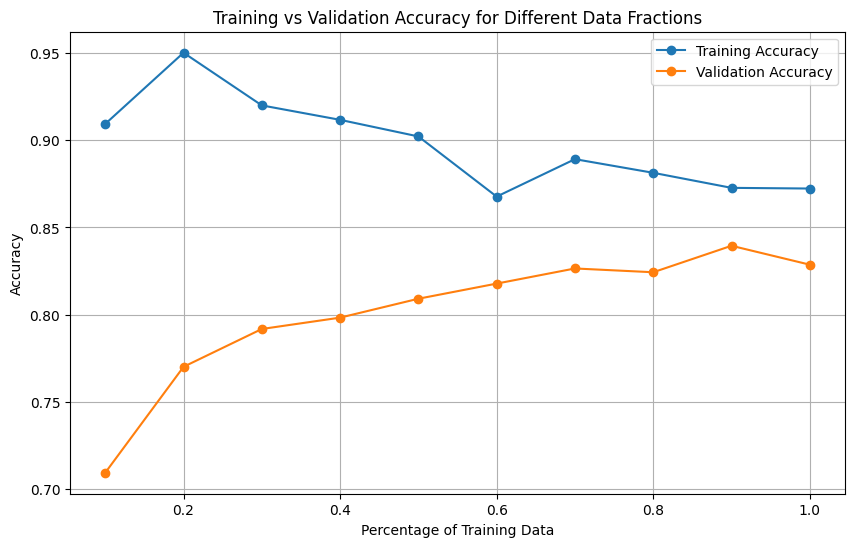

In [ ]:
# Hyperparameters for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 150],  # Limit the number of estimators to reduce training time
    'max_depth': [3, 4, 5],  # Limit depth of trees to avoid overfitting and reduce time
    'learning_rate': [0.01, 0.05, 0.1],  # Lower learning rate for better generalization
    'subsample': [0.7, 0.8, 0.9],  # Use smaller subsample to speed up training
    'colsample_bytree': [0.7, 0.8, 0.9],  # Use a smaller fraction of features
    'gamma': [0, 0.1, 0.2],  # Regularization parameter to control complexity
}

# Function to train with various data fractions and print accuracy
def train_and_evaluate(X_train_features, y_train_labels, X_valid_features, y_valid_labels, datafraction2):
    # Initialize lists to store accuracy values


    for fraction in datafraction2:
        subset_size = int(fraction * X_train_features.shape[0])
        X_train_subset = X_train_features[:subset_size]
        y_train_subset = y_train_labels[:subset_size]

        # Initialize the XGBoost classifier model
        xgb_model = xgb.XGBClassifier(eval_metric='logloss')

        # Step 1: Setup RandomizedSearchCV with 3-fold cross-validation and 10 iterations
        random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=3,
                                           verbose=1, n_jobs=-1, random_state=42)

        # Step 2: Fit the model with the training data subset
        random_search.fit(X_train_subset, y_train_subset)

        # Step 3: Make predictions on the validation dataset
        predictions = random_search.best_estimator_.predict(X_valid_features)

        # Step 4: Evaluate the model's performance using accuracy
        train_accuracy2 = random_search.best_estimator_.score(X_train_subset, y_train_subset)
        valid_accuracy2 = accuracy_score(y_valid_labels, predictions)

        # Append the accuracies to the lists
        train_accuracies2.append(train_accuracy2)
        valid_accuracies2.append(valid_accuracy2)

        # Print the results
        print(f"Training with {fraction * 100:.1f}% of data - "
              f"Train Accuracy: {train_accuracy2:.4f}, "
              f"Validation Accuracy: {valid_accuracy2:.4f}")

    # Ensure the lists have the same length as datafraction2
    if len(train_accuracies2) != len(datafraction2) or len(valid_accuracies2) != len(datafraction2):
        print(f"Error: Accuracies and data fractions have mismatched lengths!")
        return

    # Plot the accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(datafraction2, train_accuracies2, label='Training Accuracy', marker='o')
    plt.plot(datafraction2, valid_accuracies2, label='Validation Accuracy', marker='o')
    plt.xlabel("Percentage of Training Data")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy for Different Data Fractions")
    plt.legend()
    plt.grid(True)
    plt.show()

# Prepare the features and labels for training
X_train_features = pd.DataFrame(train_data['encoded_str'].tolist())
y_train_labels = train_data['label'].values

# Define the fractions of the training dataset to be used, ranging from 10% to 100%
datafraction2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Run training and evaluation for different data fractions
train_and_evaluate(X_train_features, y_train_labels, X_valid_features, y_valid_labels, datafraction2)


# Using LSTM :

# Trainable Paramters limiting:

In [ ]:

# Initialize the model
model = Sequential()
model.add(Embedding(input_dim=len(char_to_integer_mapping) + 1, output_dim=32))  # Embedding layer
model.add(LSTM(32, return_sequences=False))  # LSTM layer with 32 units
model.add(Dense(16, activation='relu'))  # Dense layer with 16 units
model.add(Dense(8, activation='relu'))  # Another Dense layer with 8 units
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Pass a small batch of data to build the model
model.build(input_shape=(None, 13))  # Shape should match the expected input, e.g., (batch_size, sequence_length)

# Now, print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 13, 32)              │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,345 (36.50 KB)

 Trainable params: 9,345 (36.50 KB)

 Non-trainable params: 0 (0.00 B)

# Proceeding with model training:

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training with 10.0% of data - Train Accuracy: 0.8187, Validation Accuracy: 0.7028
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Training with 20.0% of data - Train Accuracy: 0.8800, Validation Accuracy: 0.7310
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training with 30.0% of data - Train Accuracy: 0.9064, Validation Accuracy: 0.7766
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training with 40.0% of data - Train Accuracy: 0.9528, Validation Accuracy: 0.8069
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training with 50.0% of data - Train Accuracy: 0.9589, Validation Accuracy: 0.8460
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training with 60.0% of data - Train Accuracy: 0.9605, Validation Accuracy: 0.8134
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Training with 70.0% of data - Train Accuracy: 0.9784, Validation Accuracy: 0.8395
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training with 80.0% of data - Train Accuracy: 0.9796, Validation Accuracy: 0.8503
15/15 ━━━━━━━━━━━━━━━━━━

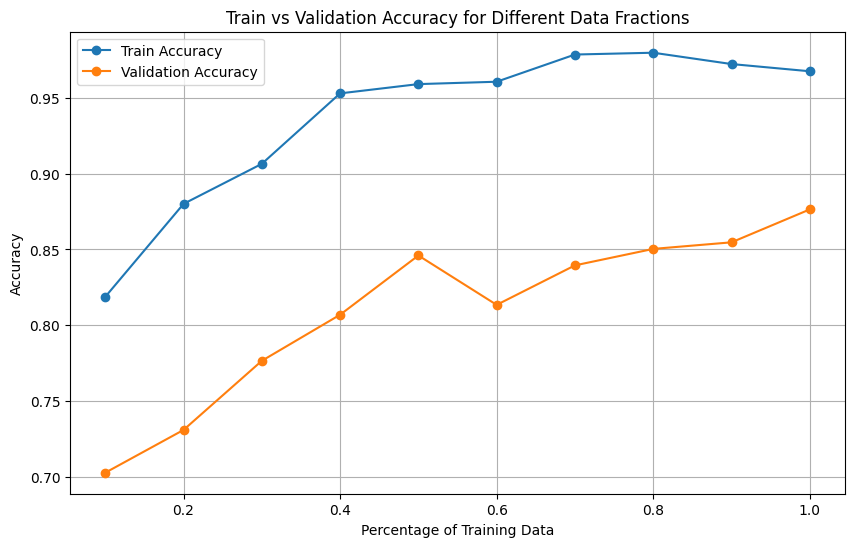

In [ ]:
# Load the datasets for training and validation
train_data = pd.read_csv("/content/train_text_seq.csv")
valid_data = pd.read_csv("/content/valid_text_seq.csv")

# Substrings to remove from the strings
remove_substrings_list = ['15436', '1596', '464', '614', '262', '422', '284']

# Function to remove the specified substrings from a sequence
def filter_substrings(sequence, substrings):
    for substring in substrings:
        sequence = sequence.replace(substring, '')  # Remove each specified substring
    return sequence

# Preprocessing function for the dataset
def clean_data(df):
    # Remove leading zeros
    df['cleaned_str'] = df['input_str'].apply(lambda x: x[3:])
    # Remove specific substrings
    df['modified_str'] = df['cleaned_str'].apply(lambda x: filter_substrings(x, remove_substrings_list))
    # Add a new column for the length of the modified string
    df['modified_length'] = df['modified_str'].apply(len)
    # Filter only strings with length 13 after modification
    df = df[df['modified_length'] == 13]
    return df

# Clean both the training and validation datasets
train_data = clean_data(train_data)
valid_data = clean_data(valid_data)

# Function to encode the strings as integer values
def string_to_int_encoding(df):
    # Create a set of all unique characters from the modified strings
    unique_chars = sorted(list(set("".join(df['modified_str'].values))))
    # Create a dictionary to map each character to a unique integer
    char_to_integer = {char: idx + 1 for idx, char in enumerate(unique_chars)}
    # Encode the modified string using the character to integer mapping
    df.loc[:, 'encoded_str'] = df['modified_str'].apply(lambda x: [char_to_integer[char] for char in x])  # Fix warning by using .loc
    return df, char_to_integer

# Apply the encoding function to both the training and validation data
train_data, char_to_integer_mapping = string_to_int_encoding(train_data)
valid_data, _ = string_to_int_encoding(valid_data)

# Prepare the data for LSTM
X_train_features = pad_sequences(train_data['encoded_str'], maxlen=13, padding='post')
y_train_labels = train_data['label'].values
X_valid_features = pad_sequences(valid_data['encoded_str'], maxlen=13, padding='post')
y_valid_labels = valid_data['label'].values

# Define the data fractions for training
datafraction3 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Function to train and evaluate the model with different fractions of the training data
def train_and_evaluate(X_train_features, y_train_labels, X_valid_features, y_valid_labels, data_fractions):

    for fraction in data_fractions:
        subset_size = int(fraction * X_train_features.shape[0])
        X_train_subset = X_train_features[:subset_size]
        y_train_subset = y_train_labels[:subset_size]

        # Define the LSTM model
        model = Sequential()
        model.add(Embedding(input_dim=len(char_to_integer_mapping) + 1, output_dim=32))  # Embedding layer
        model.add(LSTM(32, return_sequences=False))  # LSTM layer with 32 units
        model.add(Dense(16, activation='relu'))  # Dense layer with 16 units
        model.add(Dense(8, activation='relu'))  # Another Dense layer with 8 units
        model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model for 50 epochs
        model.fit(X_train_subset, y_train_subset, epochs=50, batch_size=32, validation_data=(X_valid_features, y_valid_labels), verbose=0)

        # Evaluate the model performance on the validation data
        predictions = model.predict(X_valid_features)
        predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary values

        # Calculate the accuracy
        train_accuracy3 = model.evaluate(X_train_subset, y_train_subset, verbose=0)[1]  # Get train accuracy
        valid_accuracy3 = accuracy_score(y_valid_labels, predictions)

        # Append the accuracies to the lists
        train_accuracies3.append(train_accuracy3)
        valid_accuracies3.append(valid_accuracy3)

        # Print the results
        print(f"Training with {fraction * 100:.1f}% of data - "
              f"Train Accuracy: {train_accuracy3:.4f}, "
              f"Validation Accuracy: {valid_accuracy3:.4f}")

    # Plot the accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(data_fractions, train_accuracies3, label='Train Accuracy', marker='o')
    plt.plot(data_fractions, valid_accuracies3, label='Validation Accuracy', marker='o')
    plt.xlabel("Percentage of Training Data")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation Accuracy for Different Data Fractions")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run training and evaluation for different data fractions
train_and_evaluate(X_train_features, y_train_labels, X_valid_features, y_valid_labels, datafraction3)


In [ ]:
# Check the lengths of the accuracy lists before plotting
print("Length of training_accuracies:",len(training_accuracies))
print("Length of validation_accuracies:", len(validation_accuracies))
print("Length of train_accuracies3:", len(train_accuracies3))
print("Length of valid_accuracies3:", len(valid_accuracies3))
print("Length of train_accuracies2:", len(train_accuracies2))
print("Length of valid_accuracies2:", len(valid_accuracies2))
print("Length of data_fractions:", len(data_fractions))


Length of training_accuracies: 10
Length of validation_accuracies: 10
Length of train_accuracies3: 10
Length of valid_accuracies3: 10
Length of train_accuracies2: 10
Length of valid_accuracies2: 10
Length of data_fractions: 10


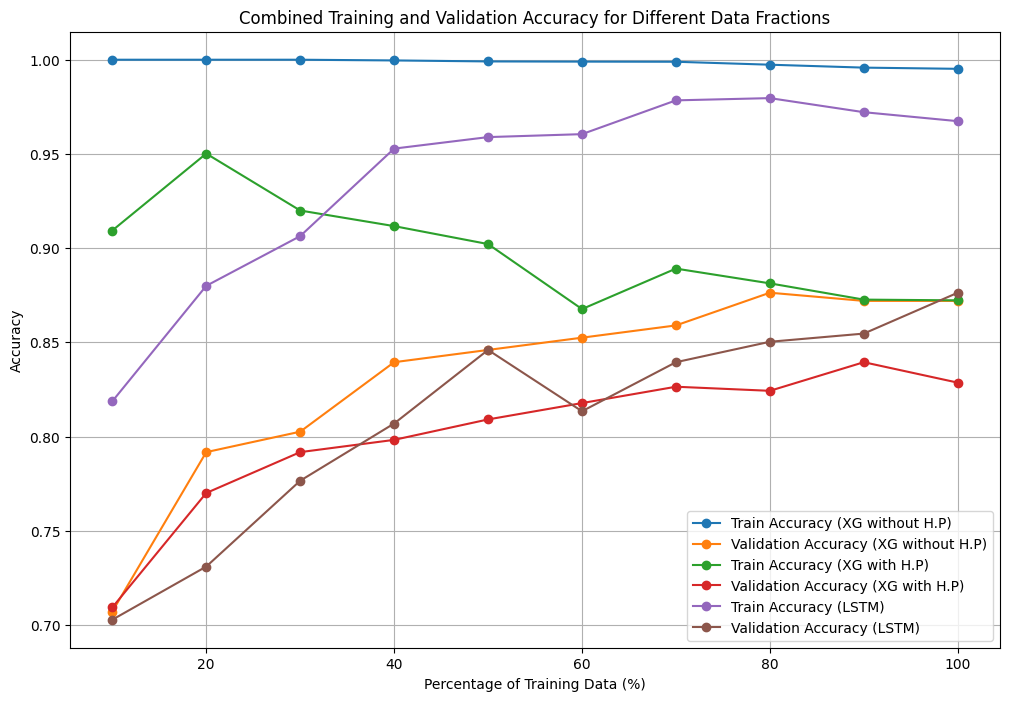

In [ ]:

# Combined plot for all three functions
plt.figure(figsize=(12, 8))

# Plot for the XG_Boosting without hyperparameters function
plt.plot(data_fractions * 100, training_accuracies, label='Train Accuracy (XG without H.P)', marker='o')
plt.plot(data_fractions * 100, validation_accuracies, label='Validation Accuracy (XG without H.P)', marker='o')

# Plot for the XG_Boosting with hyperparameters function
plt.plot(data_fractions * 100, train_accuracies2, label='Train Accuracy (XG with H.P)', marker='o')
plt.plot(data_fractions * 100, valid_accuracies2, label='Validation Accuracy (XG with H.P)', marker='o')

# Plot for the LSTM function
plt.plot(data_fractions * 100, train_accuracies3, label='Train Accuracy (LSTM)', marker='o')
plt.plot(data_fractions * 100, valid_accuracies3, label='Validation Accuracy (LSTM)', marker='o')

# Labels and title
plt.xlabel('Percentage of Training Data (%)')
plt.ylabel('Accuracy')
plt.title('Combined Training and Validation Accuracy for Different Data Fractions')

# Show the legend
plt.legend()

# Display the grid for better readability
plt.grid(True)

# Show the plot
plt.show()


# Model giving best results among tested ones -: XgBoosting (Without Hyperparameters)

###### Inference:
###### Xgboosting with hyperparameter doesn't perform better than without H.parameter since it causes model to undergo overfitting thus reduce performance on testing.

# Testing predictions:

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb

# Substrings to remove from the strings
remove_substrings_list = ['15436', '1596', '464', '614', '262', '422', '284']

# Function to remove the specified substrings from a sequence
def filter_substrings(sequence, substrings):
    for substring in substrings:
        sequence = sequence.replace(substring, '')  # Remove each specified substring
    return sequence

# Preprocessing function for the dataset
def clean_data(df):
    # Remove leading zeros
    df['cleaned_str'] = df['input_str'].apply(lambda x: x[3:])
    # Remove specific substrings
    df['modified_str'] = df['cleaned_str'].apply(lambda x: filter_substrings(x, remove_substrings_list))
    # Add a new column for the length of the modified string
    df['modified_length'] = df['modified_str'].apply(len)
    # Filter only strings with length 13 after modification
    df = df[df['modified_length'] == 13]
    return df

# Function to encode the strings as integer values
def string_to_int_encoding(df, char_to_integer=None):
    # Create a set of all unique characters from the modified strings
    if char_to_integer is None:  # If char_to_integer is not passed, generate it from the training data
        unique_chars = sorted(list(set("".join(df['modified_str'].values))))
        # Create a dictionary to map each character to a unique integer
        char_to_integer = {char: idx + 1 for idx, char in enumerate(unique_chars)}
    # Encode the modified string using the character to integer mapping
    df.loc[:, 'encoded_str'] = df['modified_str'].apply(lambda x: [char_to_integer[char] for char in x])
    return df, char_to_integer

# Load the test data
test_data = pd.read_csv('/content/test_text_seq.csv')

# Clean the test data (remove leading zeros and specific substrings)
test_data = clean_data(test_data)

# Apply the encoding function to the test data (using the same char_to_integer mapping from training)
test_data, _ = string_to_int_encoding(test_data, char_to_integer_mapping)  # Pass the char_to_integer_mapping from the training data

# Prepare the test features for prediction
X_test_features = pd.DataFrame(test_data['encoded_str'].tolist())

# Make predictions on the test data using the trained XGBoost model
test_predictions = xgb_model.predict(X_test_features)

# Save the predictions to a .txt file
output_file = '/content/pred_text_seq.txt'
np.savetxt(output_file, test_predictions, fmt='%d')  # Save predictions as integers

print(f"Predictions on the test set saved to {output_file}")


Predictions on the test set saved to /content/pred_text_seq.txt


# Importing Library :

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

# Loading the datasets :

In [ ]:

# Reading training data for the emoticon-based task
train_emoticon_data = pd.read_csv("/content/train_emoticon.csv")
emoticon_train_inputs = train_emoticon_data['input_emoticon'].tolist()
emoticon_train_labels = train_emoticon_data['label'].tolist()

# Reading validation data for the emoticon-based task
validation_emoticon_data = pd.read_csv("/content/valid_emoticon.csv")
emoticon_validation_inputs = validation_emoticon_data['input_emoticon'].tolist()
emoticon_validation_labels = validation_emoticon_data['label'].tolist()

# Reading training data for the text sequence task
train_text_data = pd.read_csv("/content/train_text_seq.csv")
text_train_inputs = train_text_data['input_str'].tolist()
text_train_labels = train_text_data['label'].tolist()

# Reading validation data for the text sequence task
validation_text_data = pd.read_csv("/content/valid_text_seq.csv")
text_validation_inputs = validation_text_data['input_str'].tolist()
text_validation_labels = validation_text_data['label'].tolist()

# Loading pre-processed feature dataset for training
feature_train_data = np.load("/content/train_feature.npz", allow_pickle=True)
features_train_inputs = feature_train_data['features']
features_train_labels = feature_train_data['label']

# Loading pre-processed feature dataset for validation
feature_validation_data = np.load("/content/valid_feature.npz", allow_pickle=True)
features_validation_inputs = feature_validation_data['features']
features_validation_labels = feature_validation_data['label']


# Dataset Details :

In [ ]:
# Display dataset sizes
print("Training dataset sizes:")
print(f"Emoticon inputs: {len(emoticon_train_inputs)}, Emoticon labels: {len(emoticon_train_labels)}")
print(f"Text sequence inputs: {len(text_train_inputs)}, Text sequence labels: {len(text_train_labels)}")
print(f"Feature matrix shape: {features_train_inputs.shape}, Feature labels shape: {features_train_labels.shape}")

print("\nValidation dataset sizes:")
print(f"Emoticon inputs: {len(emoticon_validation_inputs)}")
print(f"Text sequence inputs: {len(text_validation_inputs)}")
print(f"Feature matrix shape: {features_validation_inputs.shape}")

Training dataset sizes:
Emoticon inputs: 7080, Emoticon labels: 7080
Text sequence inputs: 7080, Text sequence labels: 7080
Feature matrix shape: (7080, 13, 768), Feature labels shape: (7080,)

Validation dataset sizes:
Emoticon inputs: 489
Text sequence inputs: 489
Feature matrix shape: (489, 13, 768)


# Data processing :

In [ ]:

# Encoding categorical data for emoticons and text sequences
encoder = OneHotEncoder(handle_unknown='ignore')

# Transform emoticon training and validation sets
encoded_emoticon_train = encoder.fit_transform(np.array(emoticon_train_inputs).reshape(-1, 1)).toarray()
encoded_emoticon_validation = encoder.transform(np.array(emoticon_validation_inputs).reshape(-1, 1)).toarray()

# Transform text sequence training and validation sets
encoded_text_train = encoder.fit_transform(np.array(text_train_inputs).reshape(-1, 1)).toarray()
encoded_text_validation = encoder.transform(np.array(text_validation_inputs).reshape(-1, 1)).toarray()

# Normalize the feature dataset using standard scaling
scaler = StandardScaler()

# Scale training features
scaled_features_train = scaler.fit_transform(features_train_inputs.reshape(features_train_inputs.shape[0], -1))

# Scale validation features
scaled_features_validation = scaler.transform(features_validation_inputs.reshape(features_validation_inputs.shape[0], -1))

# Combine all processed training data into a single matrix
train_data_combined = np.hstack((encoded_emoticon_train, encoded_text_train, scaled_features_train))
train_labels_combined = np.array(emoticon_train_labels)  # Assuming all datasets share the same labels

# Combine all processed validation data into a single matrix
validation_data_combined = np.hstack((encoded_emoticon_validation, encoded_text_validation, scaled_features_validation))
validation_labels_combined = np.array(emoticon_validation_labels)


# Combined data details :

In [ ]:
train_data_combined

array([[ 0.        ,  0.        ,  0.        , ..., -0.28983393,
        -0.24607322,  1.4753989 ],
       [ 0.        ,  0.        ,  0.        , ...,  1.64987433,
        -0.70957798,  0.2628164 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.54141045,
        -0.55918396,  0.31773353],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.7908113 ,
         1.15807533, -0.98032582],
       [ 0.        ,  0.        ,  0.        , ...,  0.64058501,
        -0.87167823, -0.86577237],
       [ 0.        ,  0.        ,  0.        , ..., -0.77007782,
         0.22331148, -1.24868262]])

# Data Fraction Selection :

In [ ]:

# Define the fractions of the training dataset to be used, ranging from 10% to 100%
data_fractions = np.linspace(0.1, 1.0, 10)

# Lists to store training and validation accuracies
training_accuracies = []
validation_accuracies = []


# On overall Dataset:



# Using Random Forest Classifer:

In [ ]:

# Loop over different fractions of the training dataset
for fraction in data_fractions:
    # Select a subset of the training data
    subset_size = int(fraction * train_data_combined.shape[0])
    train_subset_X = train_data_combined[:subset_size]
    train_subset_Y = train_labels_combined[:subset_size]

    # Initialize the Random Forest model with stronger regularization
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=8,             # Reduced max depth
        min_samples_split=10,    # Increased min samples split
        min_samples_leaf=5,      # Increased min samples per leaf
        max_features='sqrt',     # Limit the number of features considered for each split
        bootstrap=False,         # Use all data for each tree (no bootstrap sampling)
        random_state=42
    )
    rf_model.fit(train_subset_X, train_subset_Y)

    # Evaluate the model on the training subset
    train_subset_predictions = rf_model.predict(train_subset_X)
    train_subset_accuracy = accuracy_score(train_subset_Y, train_subset_predictions)

    # Evaluate the model on the full validation set
    validation_predictions = rf_model.predict(validation_data_combined)
    validation_accuracy = accuracy_score(validation_labels_combined, validation_predictions)

    # Store the results for plotting
    training_accuracies.append(train_subset_accuracy)
    validation_accuracies.append(validation_accuracy)

    print(f"Training with {fraction * 100:.1f}% of data - "
          f"Train Accuracy: {train_subset_accuracy:.4f}, "
          f"Validation Accuracy: {validation_accuracy:.4f}")


Training with 10.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.9489
Training with 20.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.9591
Training with 30.0% of data - Train Accuracy: 0.9995, Validation Accuracy: 0.9796
Training with 40.0% of data - Train Accuracy: 0.9996, Validation Accuracy: 0.9714
Training with 50.0% of data - Train Accuracy: 0.9992, Validation Accuracy: 0.9693
Training with 60.0% of data - Train Accuracy: 0.9991, Validation Accuracy: 0.9775
Training with 70.0% of data - Train Accuracy: 0.9992, Validation Accuracy: 0.9816
Training with 80.0% of data - Train Accuracy: 0.9993, Validation Accuracy: 0.9836
Training with 90.0% of data - Train Accuracy: 0.9992, Validation Accuracy: 0.9796
Training with 100.0% of data - Train Accuracy: 0.9993, Validation Accuracy: 0.9836


# Plot the results: Training and Validation Accuracy vs. Percentage of Training Data

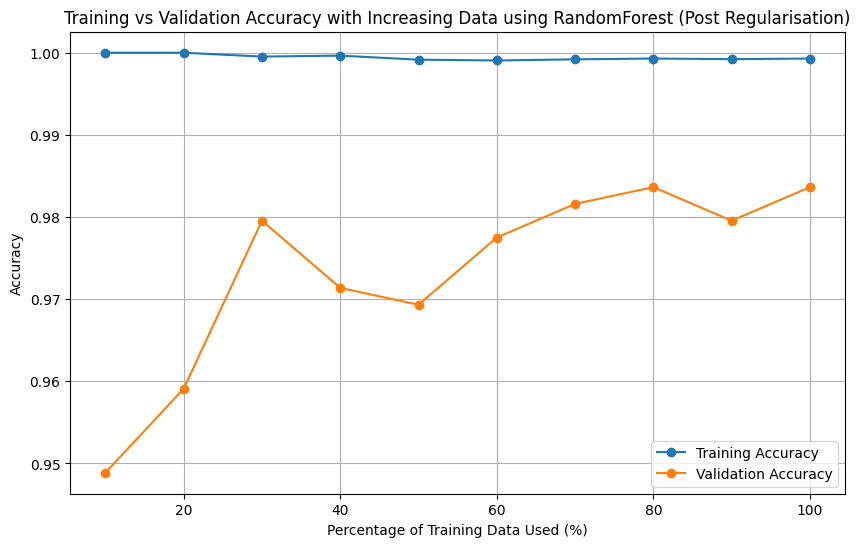

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data_fractions * 100, training_accuracies, label='Training Accuracy', marker='o')
plt.plot(data_fractions * 100, validation_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy with Increasing Data using RandomForest (Post Regularisation)')
plt.legend()
plt.grid(True)
plt.show()



# On Task Part:

## Task 1 part 1:(emoticon)

  emoticon_1 emoticon_2 emoticon_3  label
0          😻          🙠          😒      0
1          😪          🚅          😹      0
2          🚡          🙲          🛑      0
3          🙐          🙪          🛆      1
4          🚟          🙋          😹      1
Best hyperparameters: {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'invscaling', 'loss': 'perceptron', 'penalty': 'l2'}
Training on 10.0% of data - Train Accuracy: 0.9845, Validation Accuracy: 0.7791, Number of Parameters: 503
Training on 20.0% of data - Train Accuracy: 0.9823, Validation Accuracy: 0.8691, Number of Parameters: 503
Training on 30.0% of data - Train Accuracy: 0.9920, Validation Accuracy: 0.9080, Number of Parameters: 503
Training on 40.0% of data - Train Accuracy: 0.9929, Validation Accuracy: 0.9162, Number of Parameters: 503
Training on 50.0% of data - Train Accuracy: 0.9907, Validation Accuracy: 0.9182, Number of Parameters: 503
Training on 60.0% of data - Train Accuracy: 0.9894, Validation Accuracy: 0.9366, Number of P

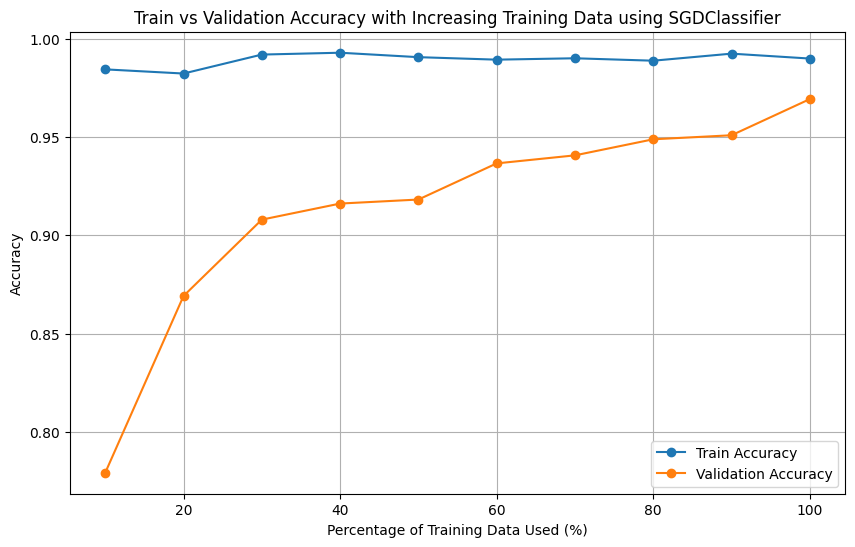

In [ ]:
training_df = pd.read_csv('train_emoticon.csv')
validation_df = pd.read_csv('valid_emoticon.csv')

# Function to extract emojis from each row
def extract_emojis(row):
    return list(row)

# Creating a set of emojis for each row
training_df['emoji_list'] = training_df['input_emoticon'].apply(extract_emojis)

# Finding common emojis across all rows
common_emojis = set(training_df['emoji_list'][0])
for emojis in training_df['emoji_list']:
    common_emojis.intersection_update(emojis)

# Removing common emojis and non-unique emojis from each row
def remove_common_and_duplicates(emojis, common):
    unique_emojis = []
    seen = set()
    for emoji in emojis:
        if emoji not in common and emoji not in seen:
            unique_emojis.append(emoji)
            seen.add(emoji)
    return ''.join(unique_emojis)

# Applying the function to remove common emojis and duplicates
training_df['non_repeating_emojis'] = training_df['emoji_list'].apply(lambda x: remove_common_and_duplicates(x, common_emojis))

# Storing only the non-repeating emojis and the label in the new CSV
training_df[['non_repeating_emojis', 'label']].to_csv('updated_training_data.csv', index=False)


# Similary for validation data

# Creating a set of emojis for each row
validation_df['emoji_list'] = validation_df['input_emoticon'].apply(extract_emojis)

# Finding common emojis across all rows
common_emojis2 = set(validation_df['emoji_list'][0])
for emojis in validation_df['emoji_list']:
    common_emojis2.intersection_update(emojis)

# Applying the function to remove common emojis and duplicates
validation_df['non_repeating_emojis'] = validation_df['emoji_list'].apply(lambda x: remove_common_and_duplicates(x, common_emojis2))

# Storing only the non-repeating emojis and the label in the new CSV
validation_df[['non_repeating_emojis', 'label']].to_csv('updated_validation_data.csv', index=False)

new_training_data = 'updated_training_data.csv'
new_validation_data = 'updated_validation_data.csv'

# Reading the datasets
train_df = pd.read_csv(new_training_data)
valid_df = pd.read_csv(new_validation_data)

# Spliting the 'non_repeating_emojis' column into separate columns for each emoji
train_df_split = train_df['non_repeating_emojis'].apply(lambda x: pd.Series(list(x)))
valid_df_split = valid_df['non_repeating_emojis'].apply(lambda x: pd.Series(list(x)))

num_emojis = 3  # number of unique emojis in the each training example row
train_df_split.columns = [f'emoticon_{i}' for i in range(1, num_emojis + 1)]
valid_df_split.columns = [f'emoticon_{i}' for i in range(1, num_emojis + 1)]

# Combining the split columns with the original 'label' column
train_df_final = pd.concat([train_df_split, train_df['label']], axis=1)
valid_df_final = pd.concat([valid_df_split, valid_df['label']], axis=1)

# Showing the first few rows of the training set after splitting
print(train_df_final.head())
# Defining the fractions of the training data to use (from 10% to 100%)
fractions = np.linspace(0.1, 1.0, 10)  # Correctly using 'fractions' from the SGDClassifier section

# Initialize lists to store accuracies and parameter counts
train_accuracies = []
valid_accuracies = []
parameter_counts = []

# Initializing the OneHotEncoder and fit it on the combined training and validation data
encoder = OneHotEncoder()
combined_data = pd.concat([train_df_final, valid_df_final]).drop(columns=['label'])
encoder.fit(combined_data)

# Defining hyperparameter grid for GridSearchCV
param_grid = {
    'loss': ['modified_huber', 'perceptron', 'hinge', 'log_loss'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-2, 1e-1, 1],  # Regularization strengths
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'eta0': [0.01, 0.1, 1]  # Initial learning rates
}

# Initializing GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(SGDClassifier(max_iter=1000), param_grid, cv=5, scoring='accuracy')

# Encode the full training data
X_train_full_encoded = encoder.transform(train_df_final.drop(columns=['label']))
y_train_full = train_df_final['label']

# Fitting the model on the entire training set to find the best hyperparameters
grid_search.fit(X_train_full_encoded, y_train_full)

# Extracting the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

for fraction in fractions:
    # Subsample the training data
    train_sample = train_df_final.sample(frac=fraction, random_state=42)

    # Separate features and labels for the subsample
    X_train_sample = train_sample.drop(columns=['label'])
    y_train_sample = train_sample['label']

    # Encode the subsampled training data using the pre-fitted encoder
    X_train_encoded = encoder.transform(X_train_sample)

    # Initialize and train the SGDClassifier with the best hyperparameters
    model = SGDClassifier(**best_params, max_iter=1000, tol=1e-3)
    model.fit(X_train_encoded, y_train_sample)

    # Predict on the training set and compute training accuracy
    y_train_pred = model.predict(X_train_encoded)
    train_accuracy = accuracy_score(y_train_sample, y_train_pred)

    # Encode and predict on the validation set
    X_valid_encoded = encoder.transform(valid_df_final.drop(columns=['label']))
    y_valid_pred = model.predict(X_valid_encoded)
    valid_accuracy = accuracy_score(valid_df_final['label'], y_valid_pred)

    # Calculating the number of parameters (features + intercepts)
    num_parameters = model.coef_.shape[1] + model.coef_.shape[0]

    # Storing accuracies and parameter counts
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    parameter_counts.append(num_parameters)

    print(f"Training on {fraction * 100:.1f}% of data - "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Accuracy: {valid_accuracy:.4f}, "
          f"Number of Parameters: {num_parameters}")

# Plotting train and validation accuracies against data fractions
plt.figure(figsize=(10, 6))

# Use 'fractions * 100' to plot against both accuracies lists
plt.plot(fractions * 100, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(fractions * 100, valid_accuracies, label='Validation Accuracy', marker='o')

plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy with Increasing Training Data using SGDClassifier')
plt.legend()
plt.grid(True)
plt.show()


## Task 1 Part 2:(Features)

Training with 10% of the data:
Validation Accuracy: 0.94
Confusion Matrix:
 [[242  10]
 [ 18 219]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       252
           1       0.96      0.92      0.94       237

    accuracy                           0.94       489
   macro avg       0.94      0.94      0.94       489
weighted avg       0.94      0.94      0.94       489

-----

Training with 20% of the data:
Validation Accuracy: 0.96
Confusion Matrix:
 [[240  12]
 [  9 228]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       252
           1       0.95      0.96      0.96       237

    accuracy                           0.96       489
   macro avg       0.96      0.96      0.96       489
weighted avg       0.96      0.96      0.96       489

-----

Training with 30% of the data:
Validation Accuracy: 0.98
Confusion Matrix:
 [[243   9]

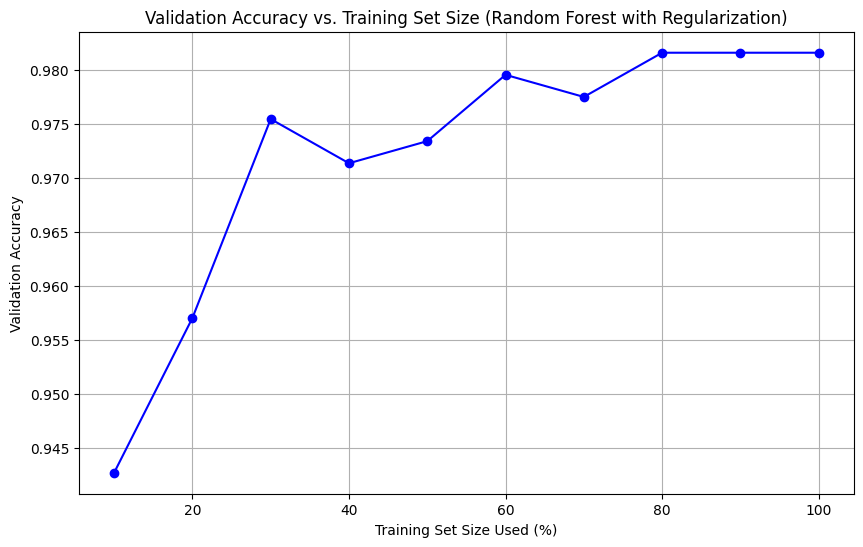

In [ ]:
# Load training feature data
training_data = np.load("/content/train_feature.npz", allow_pickle=True)
train_features = training_data['features']
train_labels = training_data['label']

# Load validation feature data
validation_data = np.load("/content/valid_feature.npz", allow_pickle=True)
valid_features = validation_data['features']
valid_labels = validation_data['label']


# Ensure labels are in integer format
train_labels = train_labels.astype(int)  # Assumes classes are 0 and 1
valid_labels = valid_labels.astype(int)  # Assumes classes are 0 and 1

# Flatten the feature arrays from (samples, 13, 786) to (samples, 13 * 786)
num_train_samples = train_features.shape[0]
num_valid_samples = valid_features.shape[0]

flat_train_features = train_features.reshape(num_train_samples, -1)
flat_valid_features = valid_features.reshape(num_valid_samples, -1)

# Normalize the feature data
scaler = StandardScaler()
flat_train_features = scaler.fit_transform(flat_train_features)
flat_valid_features = scaler.transform(flat_valid_features)
# Define the fractions of the training dataset to be used, ranging from 10% to 100%
data_fractions2 = np.linspace(0.1, 1.0, 10)

# Initialize a list to store the accuracies for each fraction of the training data
model_accuracies = []

# Train and evaluate the model for each fraction of the training data
for fraction in data_fractions2:
    # Determine the size of the subset
    subset_size = int(num_train_samples * fraction)
    subset_train_features = flat_train_features[:subset_size]
    subset_train_labels = train_labels[:subset_size]

    # Initialize and train the Random Forest model with regularization parameters
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,              # Maximum depth of each tree
        min_samples_split=5,       # Minimum samples required to split an internal node
        min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
        random_state=42
    )

    rf_model.fit(subset_train_features, subset_train_labels)

    # Predict on the validation data
    valid_predictions = rf_model.predict(flat_valid_features)

    # Measure the accuracy on the validation set
    accuracy = accuracy_score(valid_labels, valid_predictions)
    model_accuracies.append(accuracy)

    # Output metrics for each training fraction
    print(f"Training with {int(fraction * 100)}% of the data:")
    print(f"Validation Accuracy: {accuracy:.2f}")
    print("Confusion Matrix:\n", confusion_matrix(valid_labels, valid_predictions))
    print("Classification Report:\n", classification_report(valid_labels, valid_predictions))
    print("-----\n")

# Visualize the accuracy versus training data fraction
plt.figure(figsize=(10, 6))
plt.plot([int(f * 100) for f in data_fractions2], model_accuracies, marker='o', color='blue')
plt.title("Validation Accuracy vs. Training Set Size (Random Forest with Regularization)")
plt.xlabel("Training Set Size Used (%)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()


## Task 1 Part 3:(Text Sequence)

Training with 10.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.7072
Training with 20.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.7918
Training with 30.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.8026
Training with 40.0% of data - Train Accuracy: 0.9996, Validation Accuracy: 0.8395
Training with 50.0% of data - Train Accuracy: 0.9991, Validation Accuracy: 0.8460
Training with 60.0% of data - Train Accuracy: 0.9990, Validation Accuracy: 0.8525
Training with 70.0% of data - Train Accuracy: 0.9989, Validation Accuracy: 0.8590
Training with 80.0% of data - Train Accuracy: 0.9974, Validation Accuracy: 0.8764
Training with 90.0% of data - Train Accuracy: 0.9958, Validation Accuracy: 0.8720
Training with 100.0% of data - Train Accuracy: 0.9952, Validation Accuracy: 0.8720


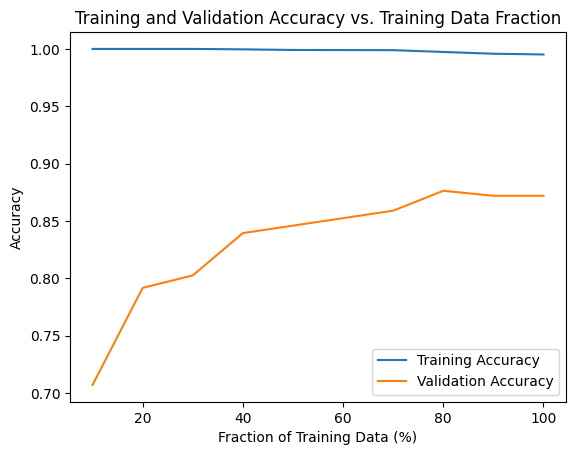

In [ ]:

# Load the training and validation datasets
train_data = pd.read_csv("/content/train_text_seq.csv")
valid_data = pd.read_csv("/content/valid_text_seq.csv")

# Substrings to remove from the strings
remove_substrings_list = ['15436', '1596', '464', '614', '262', '422', '284']

# Function to remove the specified substrings from a sequence
def filter_substrings(sequence, substrings):
    for substring in substrings:
        sequence = sequence.replace(substring, '')  # Remove each specified substring
    return sequence

# Preprocessing function for the dataset
def clean_data(df):
    # Remove leading zeros
    df['cleaned_str'] = df['input_str'].apply(lambda x: x[3:])
    # Remove specific substrings
    df['modified_str'] = df['cleaned_str'].apply(lambda x: filter_substrings(x, remove_substrings_list))
    # Add a new column for the length of the modified string
    df['modified_length'] = df['modified_str'].apply(len)
    # Filter only strings with length 13 after modification
    df = df[df['modified_length'] == 13]
    return df

# Clean both the training and validation datasets
train_data = clean_data(train_data)
valid_data = clean_data(valid_data)


# Function to encode the strings as integer values
def string_to_int_encoding(df):
    # Create a set of all unique characters from the modified strings
    unique_chars = sorted(list(set("".join(df['modified_str'].values))))
    # Create a dictionary to map each character to a unique integer
    char_to_integer = {char: idx + 1 for idx, char in enumerate(unique_chars)}
    # Encode the modified string using the character to integer mapping
    df.loc[:, 'encoded_str'] = df['modified_str'].apply(lambda x: [char_to_integer[char] for char in x])  # Fix warning by using .loc
    return df, char_to_integer

# Apply the encoding function to both the training and validation data
train_data, char_to_integer_mapping = string_to_int_encoding(train_data)
valid_data, _ = string_to_int_encoding(valid_data)

# Prepare the data for XGBoost
# Flatten the list of integers for each encoded string to create feature columns
X_train_features = pd.DataFrame(train_data['encoded_str'].tolist())
y_train_labels = train_data['label'].values

X_valid_features = pd.DataFrame(valid_data['encoded_str'].tolist())
y_valid_labels = valid_data['label'].values

# Define the fractions of the training dataset to be used, ranging from 10% to 100%
data_fractions = np.linspace(0.1, 1.0, 10)

# Lists to store training and validation accuracies
training_accuracies = []
validation_accuracies = []

# Loop over different fractions of the training dataset
for fraction in data_fractions:
    # Select a subset of the training data
    subset_size = int(fraction * train_data.shape[0])
    X_train_subset = X_train_features[:subset_size]
    y_train_subset = y_train_labels[:subset_size]

    # Initialize the XGBoost classifier model (removed use_label_encoder)
    xgb_model = xgb.XGBClassifier(eval_metric='logloss')

    # Fit the model with the training subset
    xgb_model.fit(X_train_subset, y_train_subset)

    # Make predictions on the training data subset
    train_predictions = xgb_model.predict(X_train_subset)

    # Evaluate the model's performance using accuracy on training data
    train_accuracy = accuracy_score(y_train_subset, train_predictions)

    # Make predictions on the validation dataset
    valid_predictions = xgb_model.predict(X_valid_features)

    # Evaluate the model's performance using accuracy on validation data
    valid_accuracy = accuracy_score(y_valid_labels, valid_predictions)

    # Store the results
    training_accuracies.append(train_accuracy)
    validation_accuracies.append(valid_accuracy)

    # Print the accuracies
    print(f"Training with {fraction * 100:.1f}% of data - "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Accuracy: {valid_accuracy:.4f}")

# You can plot the training and validation accuracies to see the trend
import matplotlib.pyplot as plt

plt.plot(data_fractions * 100, training_accuracies, label='Training Accuracy')
plt.plot(data_fractions * 100, validation_accuracies, label='Validation Accuracy')
plt.xlabel('Fraction of Training Data (%)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Training Data Fraction')
plt.legend()
plt.show()


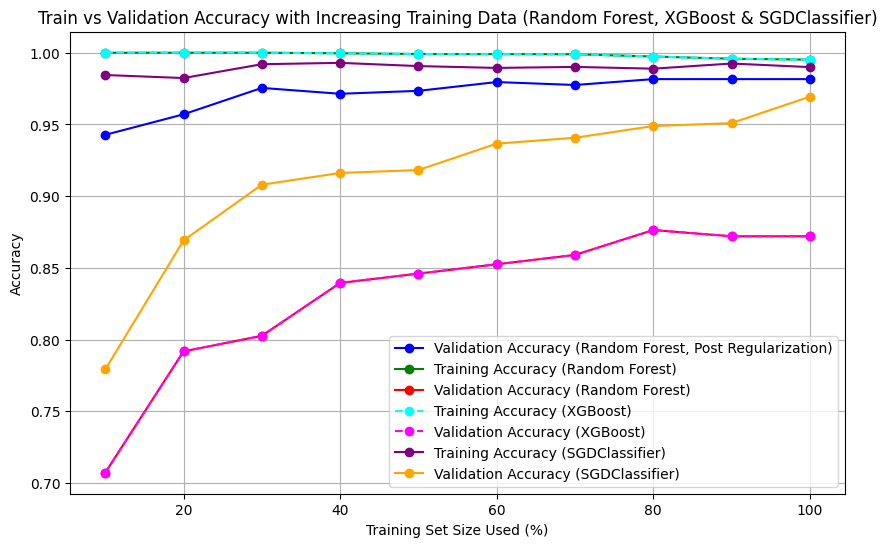

In [ ]:
import matplotlib.pyplot as plt

# Combined plot for Random Forest, XGBoost, and SGDClassifier accuracies
plt.figure(figsize=(10, 6))

# Plot the Validation Accuracy vs. Training Set Size (Random Forest with Regularization)
plt.plot([int(f * 100) for f in data_fractions2], model_accuracies, label='Validation Accuracy (Random Forest, Post Regularization)', marker='o', color='blue')

# Plot the Training and Validation Accuracies for Random Forest (pre regularization)
plt.plot(data_fractions * 100, training_accuracies, label='Training Accuracy (Random Forest)', marker='o', color='green')
plt.plot(data_fractions * 100, validation_accuracies, label='Validation Accuracy (Random Forest)', marker='o', color='red')

# Plot the Training and Validation Accuracies for XGBoost
plt.plot(data_fractions * 100, training_accuracies, label='Training Accuracy (XGBoost)', marker='o', linestyle='--', color='cyan')
plt.plot(data_fractions * 100, validation_accuracies, label='Validation Accuracy (XGBoost)', marker='o', linestyle='--', color='magenta')

# Plot the Training and Validation Accuracies for SGDClassifier
plt.plot(fractions * 100, train_accuracies, label='Training Accuracy (SGDClassifier)', marker='o', color='purple')
plt.plot(fractions * 100, valid_accuracies, label='Validation Accuracy (SGDClassifier)', marker='o', color='orange')

# Add labels, title, legend, and grid
plt.title('Train vs Validation Accuracy with Increasing Training Data (Random Forest, XGBoost & SGDClassifier)')
plt.xlabel('Training Set Size Used (%)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Test  Prediction for Task 2

In [ ]:
# Check the number of features in the training set
print(f"Training data shape: {train_data_combined.shape}")

# Ensure that the model is trained on the correct data shape
# This is a placeholder, make sure rf_model was trained on this shape
if hasattr(rf_model, "n_features_in_"):
    print(f"Model expects {rf_model.n_features_in_} features.")


rf_model.fit(train_data_combined, train_labels_combined)  # Refit the model with the correct training data

# Make predictions on the full training set
train_predictions = rf_model.predict(train_data_combined)

# Create or open a text file and write predictions
with open('pred_combined.txt', 'w') as f:
    for pred in train_predictions:
        f.write(f"{pred}\n")

print("Predictions have been written to 'pred_combined.txt'.")


Training data shape: (7080, 24144)
Model expects 9984 features.
Predictions have been written to 'pred_combined.txt'.
